In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics  
from matplotlib.legend_handler import HandlerLine2D
import seaborn as sns
import pandas as pd
import math
from astropy.table import Table
import astropy.units as u
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, RocCurveDisplay, precision_recall_curve, f1_score



In [86]:
t = Table.read('gll_psc_v16.fit')
t

Source_Name,RAJ2000,DEJ2000,GLON,GLAT,Conf_68_SemiMajor,Conf_68_SemiMinor,Conf_68_PosAng,Conf_95_SemiMajor,Conf_95_SemiMinor,Conf_95_PosAng,ROI_num,Signif_Avg,Pivot_Energy,Flux_Density,Unc_Flux_Density,Flux1000,Unc_Flux1000,Energy_Flux100,Unc_Energy_Flux100,Signif_Curve,SpectrumType,Spectral_Index,Unc_Spectral_Index,beta,Unc_beta,Cutoff,Unc_Cutoff,Exp_Index,Unc_Exp_Index,PowerLaw_Index,Flux30_100,Unc_Flux30_100,nuFnu30_100,Sqrt_TS30_100,Flux100_300,Unc_Flux100_300,nuFnu100_300,Sqrt_TS100_300,Flux300_1000,Unc_Flux300_1000,nuFnu300_1000,Sqrt_TS300_1000,Flux1000_3000,Unc_Flux1000_3000,nuFnu1000_3000,Sqrt_TS1000_3000,Flux3000_10000,Unc_Flux3000_10000,nuFnu3000_10000,Sqrt_TS3000_10000,Flux10000_100000,Unc_Flux10000_100000,nuFnu10000_100000,Sqrt_TS10000_100000,Variability_Index,Signif_Peak,Flux_Peak,Unc_Flux_Peak,Time_Peak,Peak_Interval,Flux_History,Unc_Flux_History,Extended_Source_Name,0FGL_Name,1FGL_Name,2FGL_Name,1FHL_Name,ASSOC_GAM1,ASSOC_GAM2,ASSOC_GAM3,TEVCAT_FLAG,ASSOC_TEV,CLASS1,ASSOC1,ASSOC2,Flags
,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,,,MeV,ph / (MeV s cm2),ph / (MeV s cm2),ph / (s cm2),ph / (s cm2),erg / (s cm2),erg / (s cm2),,,,,,,MeV,MeV,,,,ph / (s cm2),ph / (s cm2),erg / (s cm2),,ph / (s cm2),ph / (s cm2),erg / (s cm2),,ph / (s cm2),ph / (s cm2),erg / (s cm2),,ph / (s cm2),ph / (s cm2),erg / (s cm2),,ph / (s cm2),ph / (s cm2),erg / (s cm2),,ph / (s cm2),ph / (s cm2),erg / (s cm2),,,,ph / (s cm2),ph / (s cm2),s,s,ph / (s cm2),ph / (s cm2),,,,,,,,,,,,,,
bytes18,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32[2],float32,float32,float32,float32[2],float32,float32,float32,float32[2],float32,float32,float32,float32[2],float32,float32,float32,float32[2],float32,float32,float32,float32,float32,float32,float64,float32,float32[48],"float32[48,2]",bytes18,bytes17,bytes18,bytes18,bytes18,bytes15,bytes14,bytes15,bytes1,bytes21,bytes5,bytes26,bytes26,int16
3FGL J0000.1+6545,0.0377,65.7517,117.6939,3.4030,0.0628,0.0481,41.030,0.1019,0.0780,41.030,185,6.813,1159.08,1.0053e-12,1.4911e-13,1.0160e-09,1.5759212e-10,1.3570e-11,2.0732e-12,3.40,PowerLaw,2.4110,0.0823,-inf,-inf,-inf,-inf,-inf,-inf,2.4110,--,--,--,--,1.8083163e-08,-8.39548e-09 .. 8.236045e-09,4.1752856e-12,2.169,6.9407333e-09,-1.3528098e-09 .. 1.3669199e-09,4.543647e-12,5.270,1.2366493e-09,-2.2512775e-10 .. 2.3434676e-10,2.8553431e-12,6.022,5.78052e-11,-4.04457e-11 .. 4.8533958e-11,3.7841312e-13,1.509,2.8396294e-11,-1.484277e-11 .. 1.91547e-11,4.3172041e-13,2.421,40.753517,-inf,-inf,-inf,-inf,-inf,6.361567e-08 .. 0.0,-2.777704e-08 .. 2.0913118e-08,,,,2FGL J2359.6+6543c,,,,,N,,,,,4
3FGL J0000.2-3738,0.0612,-37.6484,345.4105,-74.9468,0.0451,0.0417,-88.550,0.0731,0.0676,-88.550,589,5.091,3296.33,1.9420e-14,5.1475e-15,2.0387e-10,5.4225336e-11,2.4051e-12,6.7044e-13,1.50,PowerLaw,1.8667,0.1794,-inf,-inf,-inf,-inf,-inf,-inf,1.8667,--,--,--,--,9.876651e-11,-- .. 1.998812e-09,2.4048505e-14,0.000,1.3424871e-10,-- .. 2.668786e-10,9.363738e-14,0.554,1.4509034e-10,-5.8052327e-11 .. 6.8154656e-11,3.5327822e-13,2.941,7.452389e-11,-2.6238078e-11 .. 3.1975783e-11,5.1979796e-13,4.154,1.5907338e-11,-9.25702e-12 .. 1.4521368e-11,2.99165e-13,3.469,44.845318,-inf,-inf,-inf,-inf,-inf,0.0 .. 1.3924737e-09,-- .. 2.1232234e-09,,,,,,,,,N,,,,,0
3FGL J0001.0+6314,0.2535,63.2440,117.2931,0.9257,0.1526,0.0986,-65.320,0.2475,0.1598,-65.320,233,6.164,472.16,8.6247e-12,1.2301e-12,6.4037e-10,1.2908612e-10,1.3029e-11,1.8859e-12,0.26,PowerLaw,2.7328,0.1075,-inf,-inf,-inf,-inf,-inf,-inf,2.7328,--,--,--,--,2.9130298e-08,-7.121452e-09 .. 7.436789e-09,6.5264105e-12,3.974,4.650789e-09,-1.1171207e-09 .. 1.1293722e-09,2.937856e-12,4.250,3.0208774e-10,-1.7640857e-10 .. 1.8435013e-10,6.768034e-13,1.748,1.1586606e-10,-4.2192454e-11 .. 4.7900017e-11,7.3191404e-13,3.275,2.0219642e-12,-- ..

In [87]:
# remove features that are not useful or contain uncertainties
good_features  = [
    "Signif_Avg", "Flux_Density", 
    "Flux1000", "Energy_Flux100", "Signif_Curve", 
    "Spectral_Index", "beta", "PowerLaw_Index", 
    "Variability_Index", "Flux_Peak", "Peak_Interval", 
    "Flux100_300", "Flux300_1000", "Flux1000_3000",
    "Flux3000_10000", "Flux10000_100000", "CLASS1"
]

initial_features_remove = [
    'Source_Name',
    'RAJ2000', 'DEJ2000', 'GLON', 'GLAT',
    'Conf_68_SemiMajor', 'Conf_68_SemiMinor', 'Conf_68_PosAng',
    'Conf_95_SemiMajor', 'Conf_95_SemiMinor', 'Conf_95_PosAng',
    'ROI_num', 'Extended_Source_Name', '0FGL_Name', '1FGL_Name',
    '2FGL_Name', '1FHL_Name', 'ASSOC_GAM1', 'ASSOC_GAM2',
    'ASSOC_GAM3', 'TEVCAT_FLAG', 'ASSOC_TEV', 'ASSOC1',
    'ASSOC2', 'Flags', 'Flux30_100', 'Unc_Flux30_100',
    'nuFnu30_100', 'Sqrt_TS30_100', 'Cutoff', 'SpectrumType',
    'Unc_Flux100_300', 'Unc_Flux300_1000', 'Unc_Flux1000_3000', 
    'Unc_Flux3000_10000', 'Unc_Flux10000_100000', 'Flux_History', 
    'Unc_Flux_History'
]

all_columns = t.colnames  # This returns a list of all column names in the table

# Step 2: Find the remaining columns after removal
usable_features = [col for col in all_columns if col not in initial_features_remove]

# doesn't include features that can be immediatly removed like name 
initial_features_remove_table = t[usable_features]
all_feature_table = t[usable_features]

# TESTING TO GRAPH ALL FEATURES INCLUDING THE ONES I HAVE CREATED
# filtered_table = t[usable_features]
filtered_table = t[good_features]

In [88]:
# only look at bll, fsrq and bcu blazars
filtered_blazarTable = filtered_table[[cls in ['bll  ', 'BLL  ', 'fsrq ','FSRQ ', 'bcu  ','BCU  '] for cls in t['CLASS1']]]
blazar_initial_features_remove_table = initial_features_remove_table[[cls in ['bll  ', 'BLL  ', 'fsrq ','FSRQ ', 'bcu  ','BCU  '] for cls in t['CLASS1']]]
all_feature_blazarTable = all_feature_table[[cls in ['bll  ', 'BLL  ', 'fsrq ','FSRQ ', 'bcu  ','BCU  '] for cls in t['CLASS1']]]

In [89]:
# calculate hardness ratio for bins: https://arxiv.org/pdf/1306.6529
    # Flux100_300
    # Flux300_1000
    # Flux1000_3000
    # Flux3000_10000
    # Flux10000_100000


# HR = (EFj - EFi)/(EFj + EFi)
# HR100_300_1000
E1i = math.log(100) + (math.log(300)-math.log(100))/2
E1j = math.log(300) + (math.log(1000)-math.log(300))/2

# HR300_1000_3000
E2i = E1j
E2j = math.log(1000) + (math.log(3000)-math.log(1000))/2

# HR1000_3000_10000
E3i = E2j
E3j = math.log(3000) + (math.log(10000)-math.log(3000))/2

# HR3000_10000_100000
E4i = E3j
E4j = math.log(10000) + (math.log(100000)-math.log(10000))/2


filtered_blazarTable['HR1'] = (E1i*np.log(filtered_blazarTable['Flux100_300']) - E1j*np.log(filtered_blazarTable['Flux300_1000']))/(E1i*np.log(filtered_blazarTable['Flux100_300']) + E1j*np.log(filtered_blazarTable['Flux300_1000']))
filtered_blazarTable['HR2'] = (E2i*np.log(filtered_blazarTable['Flux300_1000']) - E2j*np.log(filtered_blazarTable['Flux1000_3000']))/(E2i*np.log(filtered_blazarTable['Flux300_1000']) + E2j*np.log(filtered_blazarTable['Flux1000_3000']))
filtered_blazarTable['HR3'] = (E3i*np.log(filtered_blazarTable['Flux1000_3000']) - E3j*np.log(filtered_blazarTable['Flux3000_10000']))/(E3i*np.log(filtered_blazarTable['Flux1000_3000']) + E3j*np.log(filtered_blazarTable['Flux3000_10000']))
filtered_blazarTable['HR4'] = (E4i*np.log(filtered_blazarTable['Flux3000_10000']) - E4j*np.log(filtered_blazarTable['Flux10000_100000']))/(E4i*np.log(filtered_blazarTable['Flux3000_10000']) + E4j*np.log(filtered_blazarTable['Flux10000_100000']))

filtered_blazarTable['HS1'] = filtered_blazarTable['HR1'] - filtered_blazarTable['HR2']
filtered_blazarTable['HS2'] = filtered_blazarTable['HR2'] - filtered_blazarTable['HR3']
filtered_blazarTable['HS3'] = filtered_blazarTable['HR3'] - filtered_blazarTable['HR4']

# now can remove the flux100_300 ... etc 
fluxes = [
    'Flux100_300',
    'Flux300_1000',
    'Flux1000_3000',
    'Flux3000_10000',
    'Flux10000_100000'
]

all_columns_in_filtered = filtered_blazarTable.colnames  # This returns a list of all column names in the table

# Step 2: Find the remaining columns after removal
no_flux = [col for col in all_columns_in_filtered if col not in fluxes]

# doesn't include features that can be immediatly removed like name 
filtered_blazarTable = filtered_blazarTable[no_flux]

all_feature_blazarTable['HR1'] = (E1i*np.log(all_feature_blazarTable['Flux100_300']) - E1j*np.log(all_feature_blazarTable['Flux300_1000']))/(E1i*np.log(all_feature_blazarTable['Flux100_300']) + E1j*np.log(all_feature_blazarTable['Flux300_1000']))
all_feature_blazarTable['HR2'] = (E2i*np.log(all_feature_blazarTable['Flux300_1000']) - E2j*np.log(all_feature_blazarTable['Flux1000_3000']))/(E2i*np.log(all_feature_blazarTable['Flux300_1000']) + E2j*np.log(all_feature_blazarTable['Flux1000_3000']))
all_feature_blazarTable['HR3'] = (E3i*np.log(all_feature_blazarTable['Flux1000_3000']) - E3j*np.log(all_feature_blazarTable['Flux3000_10000']))/(E3i*np.log(all_feature_blazarTable['Flux1000_3000']) + E3j*np.log(all_feature_blazarTable['Flux3000_10000']))
all_feature_blazarTable['HR4'] = (E4i*np.log(all_feature_blazarTable['Flux3000_10000']) - E4j*np.log(all_feature_blazarTable['Flux10000_100000']))/(E4i*np.log(all_feature_blazarTable['Flux3000_10000']) + E4j*np.log(all_feature_blazarTable['Flux10000_100000']))

all_feature_blazarTable['HS1'] = all_feature_blazarTable['HR1'] - all_feature_blazarTable['HR2']
all_feature_blazarTable['HS2'] = all_feature_blazarTable['HR2'] - all_feature_blazarTable['HR3']
all_feature_blazarTable['HS3'] = all_feature_blazarTable['HR3'] - all_feature_blazarTable['HR4']



In [90]:
# normalising Flux peak
filtered_blazarTable['Normalised_Flux_Peak'] = filtered_blazarTable['Flux_Peak']/filtered_blazarTable['Energy_Flux100']
filtered_blazarTable['loggedFlux_Density'] = np.log(filtered_blazarTable['Flux_Density'])
all_feature_blazarTable['Normalised_Flux_Peak'] = all_feature_blazarTable['Flux_Peak']/all_feature_blazarTable['Energy_Flux100']
all_feature_blazarTable['loggedFlux_Density'] = np.log(all_feature_blazarTable['Flux_Density'])


In [91]:
mask_bll_filtered = (filtered_blazarTable['CLASS1'] == 'bll  ') | (filtered_blazarTable['CLASS1'] == 'BLL  ')
mask_fsrq_filtered = (filtered_blazarTable['CLASS1'] == 'fsrq ') | (filtered_blazarTable['CLASS1'] == 'FSRQ ')
mask_bcu_filtered = (filtered_blazarTable['CLASS1'] == 'bcu  ') | (filtered_blazarTable['CLASS1'] == 'BCU  ')

mask_bll_all = (all_feature_blazarTable['CLASS1'] == 'bll  ') | (all_feature_blazarTable['CLASS1'] == 'BLL  ')
mask_fsrq_all= (all_feature_blazarTable['CLASS1'] == 'fsrq ') | (all_feature_blazarTable['CLASS1'] == 'FSRQ ')
mask_bcu_all = (all_feature_blazarTable['CLASS1'] == 'bcu  ') | (all_feature_blazarTable['CLASS1'] == 'BCU  ')

mask_bll_initial_remove = (blazar_initial_features_remove_table['CLASS1'] == 'bll  ') | (blazar_initial_features_remove_table['CLASS1'] == 'BLL  ')
mask_fsrq_initial_remove= (blazar_initial_features_remove_table['CLASS1'] == 'fsrq ') | (blazar_initial_features_remove_table['CLASS1'] == 'FSRQ ')
mask_bcu_initial_remove = (blazar_initial_features_remove_table['CLASS1'] == 'bcu  ') | (blazar_initial_features_remove_table['CLASS1'] == 'BCU  ')

In [92]:
for col in filtered_blazarTable.colnames:
    filtered_blazarTable[col][filtered_blazarTable[col] == -np.inf] = np.nan
for col in all_feature_blazarTable.colnames:
    all_feature_blazarTable[col][all_feature_blazarTable[col] == -np.inf] = np.nan
for col in blazar_initial_features_remove_table.colnames:
    blazar_initial_features_remove_table[col][blazar_initial_features_remove_table[col] == -np.inf] = np.nan

In [93]:
# RF ready table, only BLL and FSRQ
mask = [(cls in ['bll  ', 'BLL  ', 'fsrq ', 'FSRQ ']) for cls in filtered_blazarTable['CLASS1']]
RF_ready_filtered_blazarTable = filtered_blazarTable[mask]

mask = [(cls in ['bll  ', 'BLL  ', 'fsrq ', 'FSRQ ']) for cls in all_feature_blazarTable['CLASS1']]
RF_ready_all_feature_blazarTable = all_feature_blazarTable[mask]

mask = [(cls in ['bll  ', 'BLL  ', 'fsrq ', 'FSRQ ']) for cls in blazar_initial_features_remove_table['CLASS1']]
RF_ready_intial_feature_remove_blazarTable = blazar_initial_features_remove_table[mask]


In [94]:
# make it so that bll or BLL are just BLL, fsrq or FSRQ are FSRQ

RF_ready_filtered_blazarTable['CLASS1'] = ['BLL' if cls in ['bll  ', 'BLL  '] else 'FSRQ' if cls in [ 'fsrq ', 'FSRQ '] else cls for cls in RF_ready_filtered_blazarTable['CLASS1']]

RF_ready_all_feature_blazarTable['CLASS1'] = ['BLL' if cls in ['bll  ', 'BLL  '] else 'FSRQ' if cls in [ 'fsrq ', 'FSRQ '] else cls for cls in RF_ready_all_feature_blazarTable['CLASS1']]

RF_ready_intial_feature_remove_blazarTable['CLASS1'] = ['BLL' if cls in ['bll  ', 'BLL  '] else 'FSRQ' if cls in [ 'fsrq ', 'FSRQ '] else cls for cls in RF_ready_intial_feature_remove_blazarTable['CLASS1']]

In [141]:
# keep the good features, remove the highly correlated features
# removing Signif_Avg, Energy_Flux100, Flux1000, spectral_Index

# after the correlation matrix, these features are uncorrelated:
pre_feature_selection_good_features = [
    "loggedFlux_Density",
    "Flux1000",
    "Signif_Curve",
    "PowerLaw_Index",
    "Variability_Index",
    "Normalised_Flux_Peak",
    "Peak_Interval",
    "beta",
    "HR1",
    "HR3",
    "HR4"
]

# pre_feature_selection_good_features = [
#     "Flux_Density",
#     "loggedFlux_Density",
#     "Signif_Curve",
#     "beta",
#     "PowerLaw_Index",
#     "Variability_Index",
#     "Normalised_Flux_Peak",
#     "Peak_Interval",
#     "HR1",
#     "HR2",
#     "HR3",
#     "HR4",
#     "HS1",
#     "HS2",
#     "HS3"
    
# ]

old_features = [
    "Signif_Avg",
    "Energy_Flux100",
    "Spectral_Index",
    "Flux_Density",
    "loggedFlux_Density",
    "Signif_Curve",
    "beta",
    "PowerLaw_Index",
    "Variability_Index",
    "Normalised_Flux_Peak",
    "Peak_Interval",
    "HR1",
    "HR2",
    "HR3",
    "HR4",
    "HS1",
    "HS2",
    "HS3"
]


# FULLY FILTERED FEATURES
X_fully_filtered = RF_ready_filtered_blazarTable[pre_feature_selection_good_features].to_pandas()
y_fully_filtered = RF_ready_filtered_blazarTable['CLASS1'].data

# FEATURES WITH PRELIMINARY REMOVAL, BUT BEFRE CORRELATION MATRIX
X_including_correlation = RF_ready_filtered_blazarTable.to_pandas()
X_including_correlation = X_including_correlation.drop(columns=['CLASS1'])
y_including_correlation = RF_ready_filtered_blazarTable['CLASS1'].data

# ALL FEATURES (INCLUDING CREATED)
all_features = RF_ready_all_feature_blazarTable.colnames
all_features.remove('CLASS1')
X_all_features = RF_ready_all_feature_blazarTable[all_features].to_pandas()
y_all_features = RF_ready_all_feature_blazarTable['CLASS1'].data

# ALL FEATURES BUT WITH NO CREATED FEATURES
X_all_no_created = RF_ready_intial_feature_remove_blazarTable.to_pandas()
X_all_no_created = X_all_no_created.drop(columns=['CLASS1'])
y_all_no_created = RF_ready_intial_feature_remove_blazarTable['CLASS1'].data


# training, testing split
# FULLY FILTERED FEATURES
X_fully_filtered_train, X_fully_filtered_test, y_fully_filtered_train, y_fully_filtered_test = train_test_split(X_fully_filtered, y_fully_filtered, test_size = 0.30, random_state=40)

# FEATURES WITH PRELIMINARY REMOVAL, BUT BEFRE CORRELATION MATRIX
X_including_correlation_train, X_including_correlation_test, y_including_correlation_train, y_including_correlation_test = train_test_split(X_including_correlation, y_including_correlation, test_size = 0.30, random_state=40)

# ALL FEATURES (INCLUDING CREATED)
X_all_features_train, X_all_features_test, y_all_features_train, y_all_features_test = train_test_split(X_all_features, y_all_features, test_size = 0.30, random_state=40)

# ALL FEATURES BUT WITH NO CREATED FEATURES
X_all_no_created_train, X_all_no_created_test, y_all_no_created_train, y_all_no_created_test = train_test_split(X_all_no_created, y_all_no_created, test_size = 0.30, random_state=40)


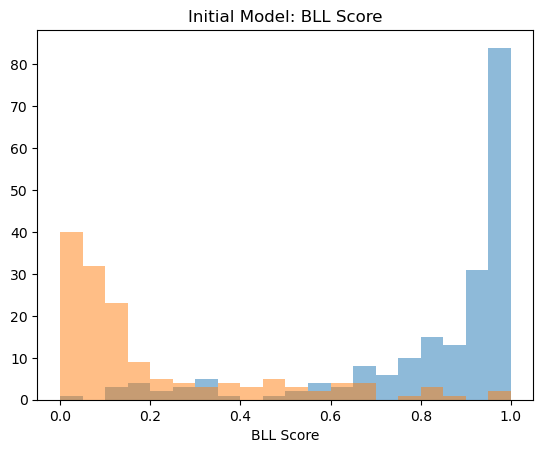

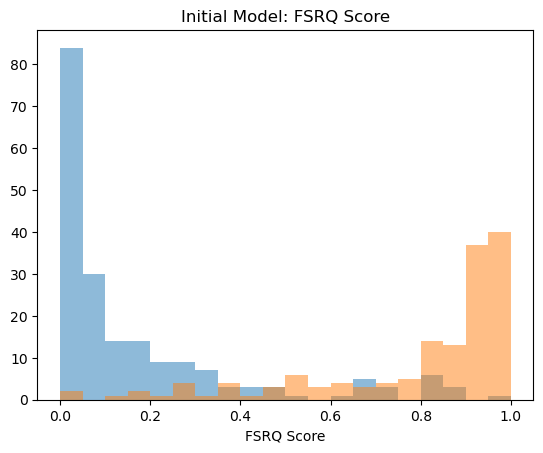

In [185]:
# testing RF on fully filterd data
rf = RandomForestClassifier()  
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
rf.fit(X_fully_filtered_train, y_fully_filtered_train)
 
# performing predictions on the test dataset
y_pred = rf.predict_proba(X_fully_filtered_test)

plt.hist(y_pred[y_fully_filtered_test=='BLL'][:,0], range= (0,1), bins=20, alpha=0.5) 
plt.hist(y_pred[y_fully_filtered_test=='FSRQ'][:,0], range= (0,1), bins=20, alpha=0.5)  
plt.title("Initial Model: BLL Score")
plt.xlabel("BLL Score")
plt.show()

plt.hist(y_pred[y_fully_filtered_test=='BLL'][:,1], range= (0,1), bins=20, alpha=0.5) 
plt.hist(y_pred[y_fully_filtered_test=='FSRQ'][:,1], range= (0,1), bins=20, alpha=0.5)  
plt.title("Initial Model: FSRQ Score")
plt.xlabel("FSRQ Score")
plt.show()

In [143]:
# # cross validation
# num_folds = 5
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# # creating a RF classifier
# rf = RandomForestClassifier()  

# fully_filtered_cross_val_results = cross_val_predict(rf, X_fully_filtered_train, y_fully_filtered_train, cv=kf, method='predict_proba')
# including_correlation_cross_val_results = cross_val_predict(rf, X_including_correlation_train, y_including_correlation_train, cv=kf, method='predict_proba')
# all_features_cross_val_results = cross_val_predict(rf, X_all_features_train, y_all_features_train, cv=kf, method='predict_proba')
# all_no_created_cross_val_results = cross_val_predict(rf, X_all_no_created_train, y_all_no_created_train, cv=kf, method='predict_proba')



In [144]:
# # cross validation score graph for fully_filtered
# plt.hist(fully_filtered_cross_val_results[y_fully_filtered_train=='BLL'][:,0], range= (0,1), label='bll', bins=20, alpha=0.5) # BLL
# plt.hist(fully_filtered_cross_val_results[y_fully_filtered_train=='FSRQ'][:,0], range= (0,1), label='fsrq', bins=20, alpha=0.5) # FSRQ

# plt.legend()
# plt.xlabel("BLL Score")
# plt.show()

In [186]:
# Cross validation roc curve and auc function 
def plot_roc_auc(X_array, y_array, positive_class_label, title_prefix):
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()
    
    # Set up the cross-validation
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    rf = RandomForestClassifier()
    
    # Loop through each fold
    for i, (train, test) in enumerate(kf.split(X_array, y_array)):
        # Fit the model on the training data
        rf.fit(X_array[train], y_array[train])
        
        # Predict the probabilities on the test data
        if positive_class_label == 'BLL':
            y_proba = rf.predict_proba(X_array[test])[:,0] #0 for the positive class being BLL
            fpr, tpr, _ = roc_curve(y_array[test], y_proba, pos_label='BLL') # Calculate the ROC
        elif positive_class_label == 'FSRQ':
            y_proba = rf.predict_proba(X_array[test])[:,1] #1 for the positive class being FSRQ
            fpr, tpr, _ = roc_curve(y_array[test], y_proba, pos_label='FSRQ') # Calculate the ROC

        roc_auc = auc(fpr, tpr) # Calculate the AUC
        
        # Interpolate the TPR for a common mean FPR
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0 # making sure that the first value is 0 so that the curve starts at 0 (0% false positive rate and 0% true positive rate)
        tprs.append(interp_tpr)
        aucs.append(roc_auc)
        
        # Plot the ROC curve for the current fold
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i} (AUC = {roc_auc:.2f})')
    
    # Plot the mean ROC curve across all folds
    mean_tpr = np.mean(tprs, axis=0) # find the mean tpr
    mean_tpr[-1] = 1.0 # making sure that the last value of mean_tpr = 1
    mean_auc = auc(mean_fpr, mean_tpr) # find the mean AUC
    std_auc = np.std(aucs) # find standard deviation in the AUC
    
    ax.plot(mean_fpr, mean_tpr, color='b', lw=2, alpha=0.8, label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )
    
    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
    )
    
    # Final plot settings
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title=f"{title_prefix}:Receiver Operating Characteristic with Cross-Validation")
    ax.legend(loc="lower right")

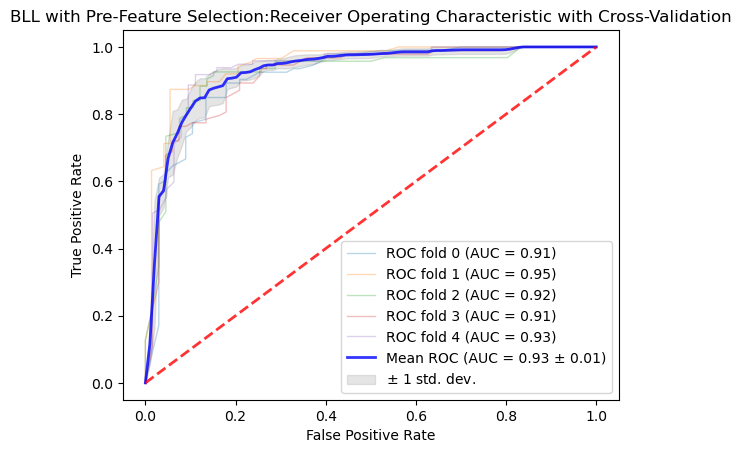

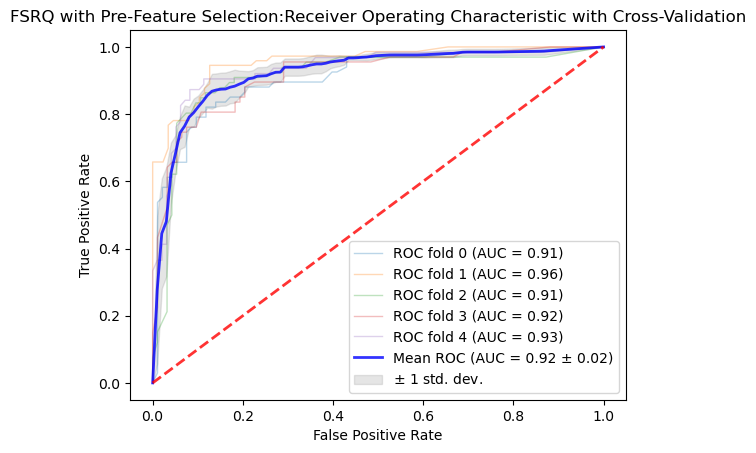

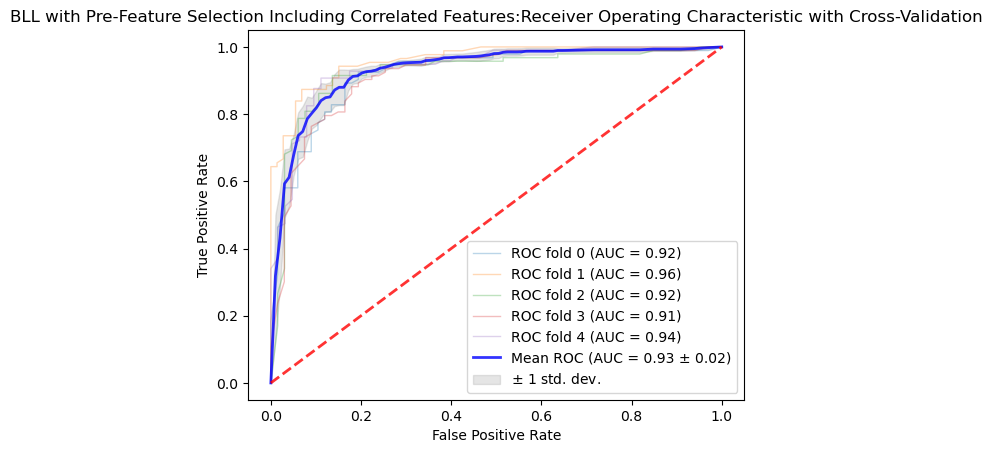

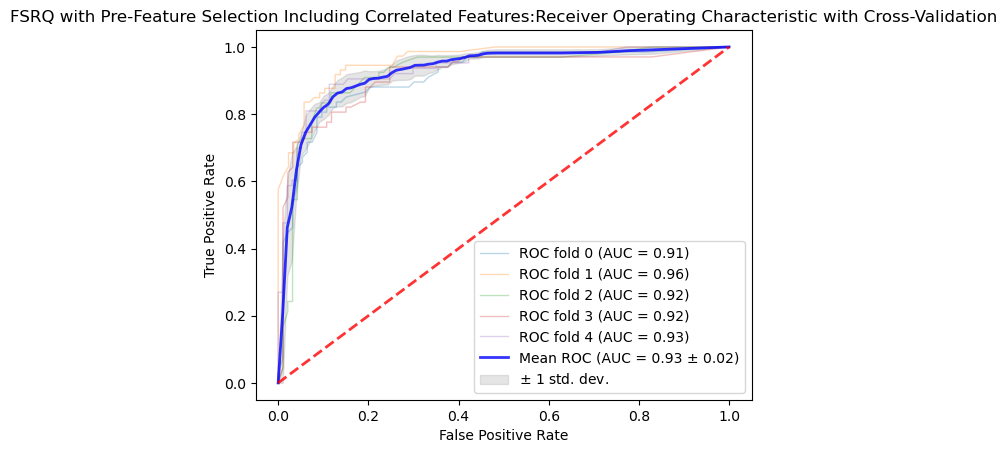

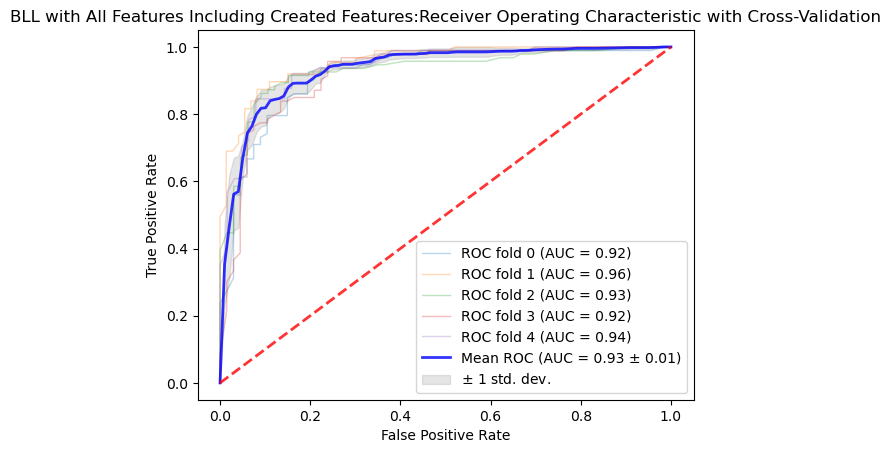

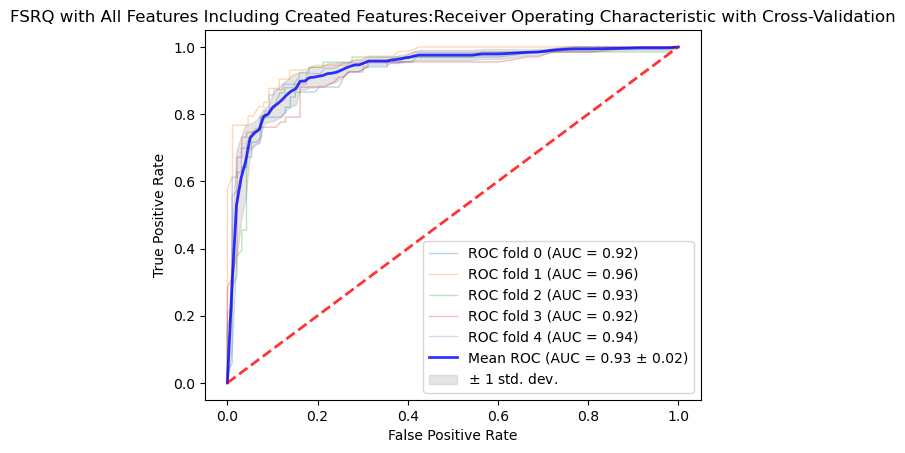

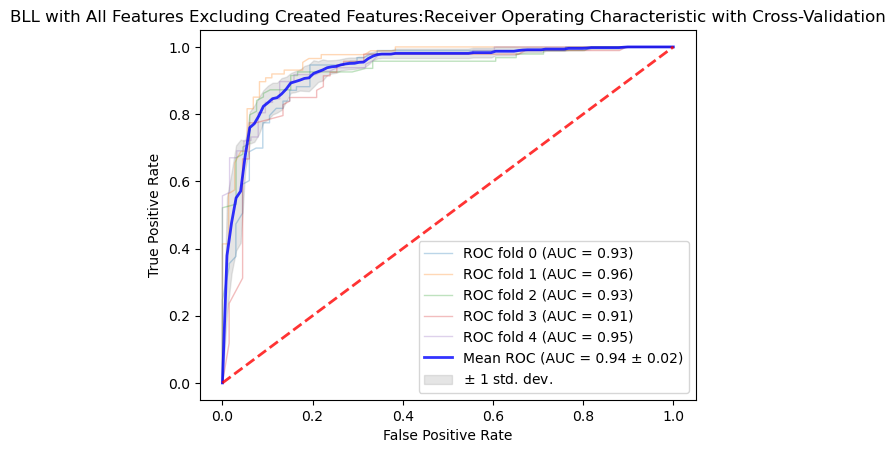

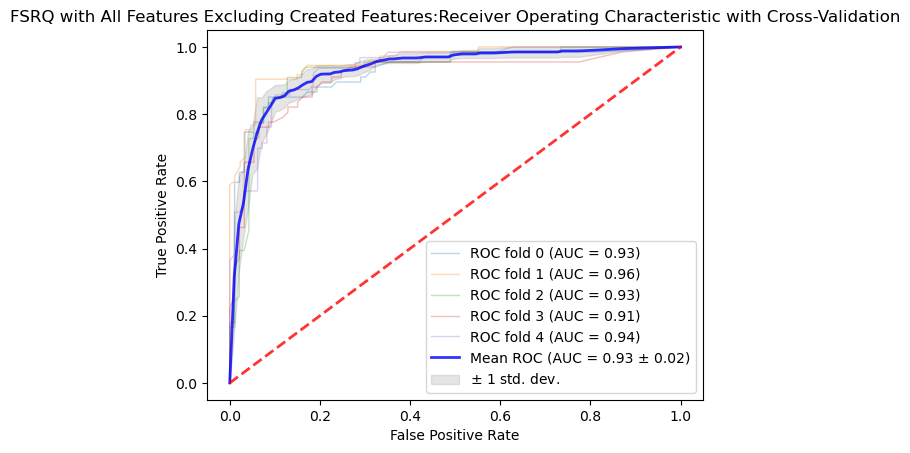

In [187]:
# ROC and AUC
# FULLY FILTERED
X_array = np.array(X_fully_filtered_train)  
y_array = np.array(y_fully_filtered_train)
plot_roc_auc(X_array, y_array, positive_class_label='BLL', title_prefix='BLL with Pre-Feature Selection')
plot_roc_auc(X_array, y_array, positive_class_label='FSRQ', title_prefix='FSRQ with Pre-Feature Selection')


# FEATURES WITH PRELIMINARY REMOVAL, BUT BEFRE CORRELATION MATRIX
X_array = np.array(X_including_correlation_train) 
y_array = np.array(y_including_correlation_train)
plot_roc_auc(X_array, y_array, positive_class_label='BLL', title_prefix='BLL with Pre-Feature Selection Including Correlated Features')
plot_roc_auc(X_array, y_array, positive_class_label='FSRQ', title_prefix='FSRQ with Pre-Feature Selection Including Correlated Features')

# ALL FEATURES (INCLUDING CREATED)
X_array = np.array(X_all_features_train) 
y_array = np.array(y_all_features_train)
plot_roc_auc(X_array, y_array, positive_class_label='BLL', title_prefix='BLL with All Features Including Created Features')
plot_roc_auc(X_array, y_array, positive_class_label='FSRQ', title_prefix='FSRQ with All Features Including Created Features')

# ALL FEATURES BUT WITH NO CREATED FEATURES
X_array = np.array(X_all_no_created_train) 
y_array = np.array(y_all_no_created_train)
plot_roc_auc(X_array, y_array, positive_class_label='BLL', title_prefix='BLL with All Features Excluding Created Features')
plot_roc_auc(X_array, y_array, positive_class_label='FSRQ', title_prefix='FSRQ with All Features Excluding Created Features')


In [188]:
# graphing precision and recall and f-score
def plot_precision_recall_fscore(X_train, y_train, positive_class_label, title_prefix):
    X_array = np.array(X_train)  
    y_array = np.array(y_train)

    precisions, recalls = [], []
    label_mapping = {'FSRQ': 0, 'BLL': 1} if positive_class_label == 'BLL' else {'FSRQ': 1, 'BLL': 0}

    y_array_numeric = np.array([label_mapping[label] for label in y_array])

    mean_thresholds = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()
    
    # Set up the cross-validation
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    rf = RandomForestClassifier()
    
    # Loop through each fold
    for i, (train, test) in enumerate(kf.split(X_array, y_array_numeric)):
        # Fit the model on the training data
        rf.fit(X_array[train], y_array_numeric[train])



        y_proba = rf.predict_proba(X_array[test])[:,1] #1 for the positive class
        precision, recall, thresholds = precision_recall_curve(y_array_numeric[test], y_proba, pos_label=1)
        # remove last element from precision and recall
        precision = precision[:-1]
        recall = recall[:-1]
    
        # calculate f1-score for threshold > t
        f1_scores = []
        for t in thresholds:
            f1 = f1_score(y_array_numeric[test], (y_proba > t).astype(int), pos_label=1)
            f1_scores.append(f1)

        ax.plot(thresholds, precision, lw=1, alpha=0.3, color="darkorange")
        ax.plot(thresholds, recall, lw=1, alpha=0.3, color="blue")
        ax.plot(thresholds, f1_scores, lw=1, alpha=0.3, color="green")

    
    # find average by looking at the full set of the cross_val_results
    cross_val_results = cross_val_predict(rf, X_array, y_array_numeric, cv=kf, method='predict_proba')  
    CV_f1_scores = []

    CV_precision, CV_recall, CV_thresholds = precision_recall_curve(y_array_numeric, cross_val_results[:,1], pos_label=1)
    for t in CV_thresholds:
        f1 = f1_score(y_array_numeric, (cross_val_results[:,1] > t).astype(int), pos_label=1)
        CV_f1_scores.append(f1)

        
    ax.plot(CV_thresholds, CV_precision[:-1], lw=1, alpha=1, color="darkorange", label='Precision')
    ax.plot(CV_thresholds, CV_recall[:-1], lw=1, alpha=1, color="darkblue", label='Recall')
    ax.plot(CV_thresholds, CV_f1_scores, lw=1, alpha=1, color="green", label='F1-score')
    
    
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
    ax.grid(True)
    
    # Set labels and titles
    ax.set(xlabel="Threshold", ylabel="Score", title=f"{title_prefix}: Precision and Recall vs. Threshold")

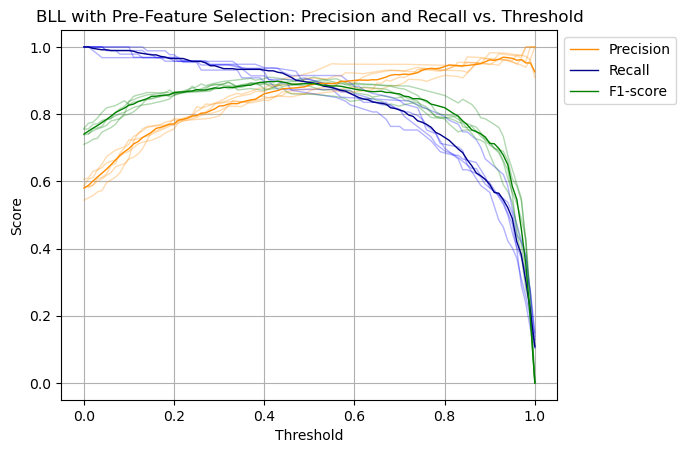

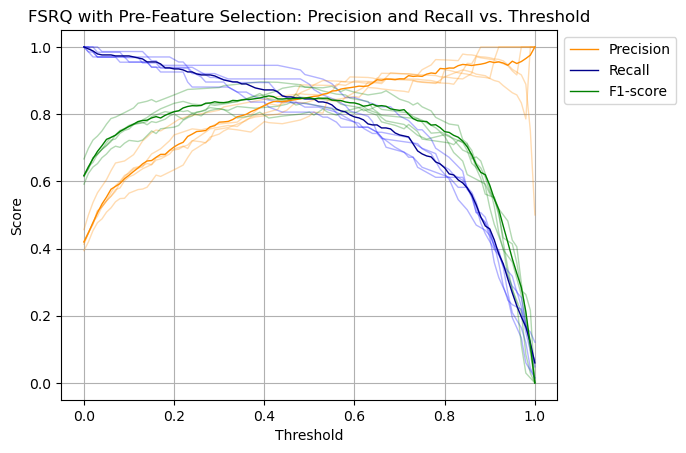

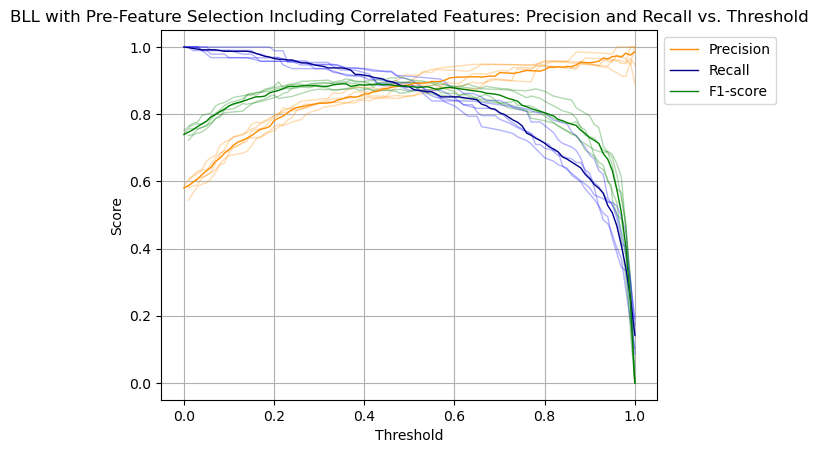

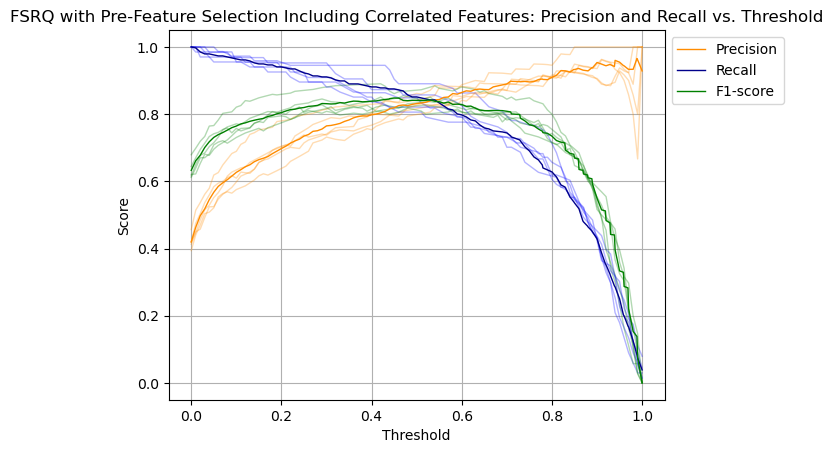

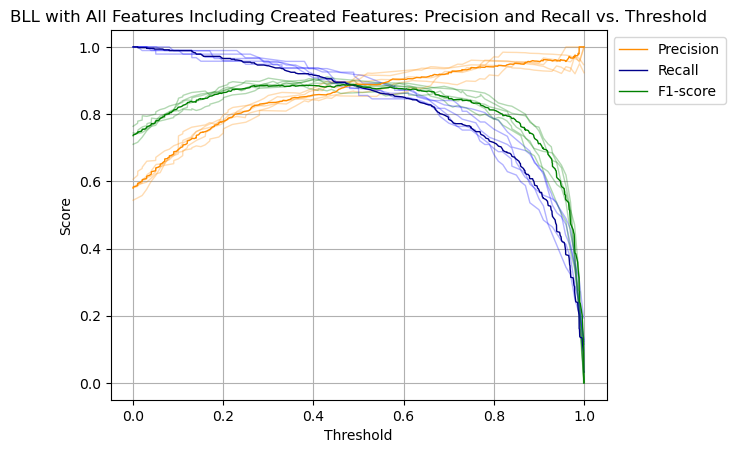

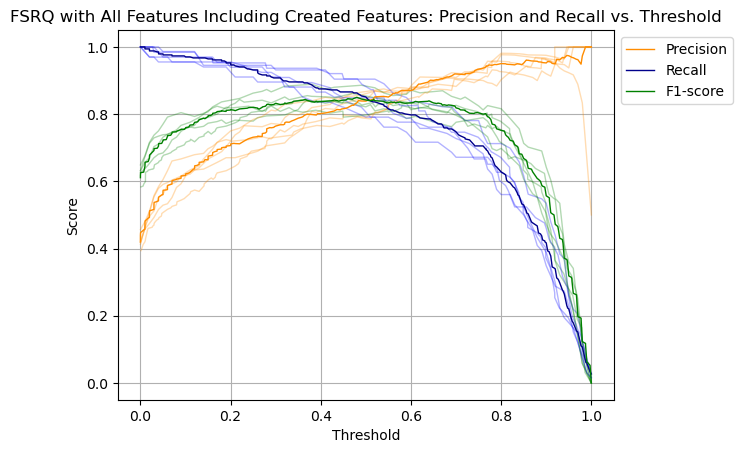

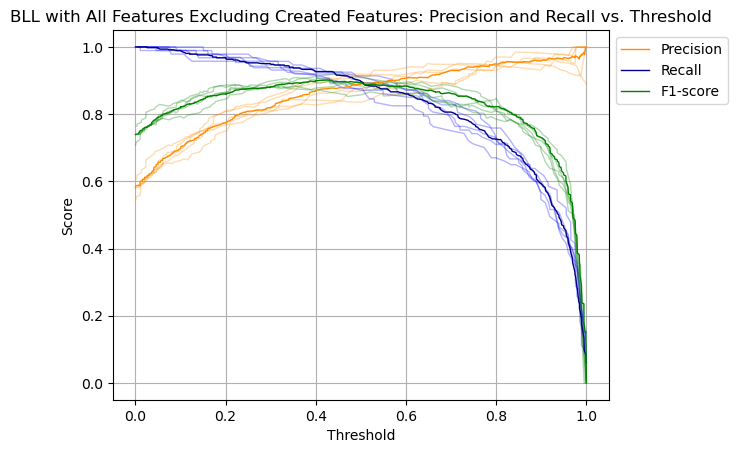

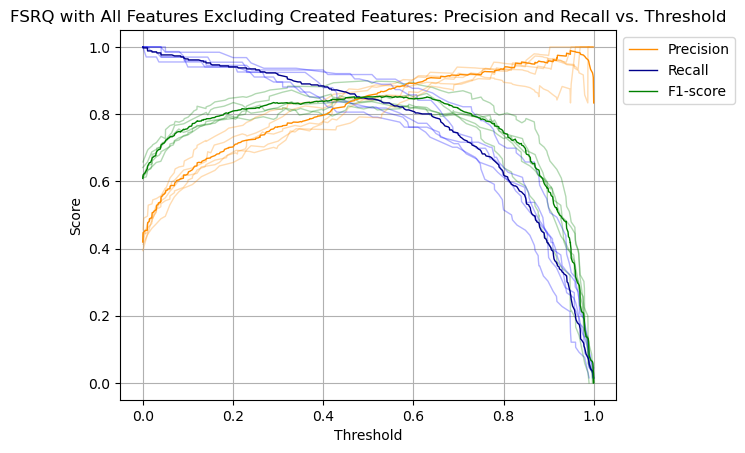

In [189]:
# # Graph precision and recall and f-score
# FULLY FILTERED
plot_precision_recall_fscore(X_fully_filtered_train, y_fully_filtered_train, positive_class_label='BLL', title_prefix='BLL with Pre-Feature Selection')
plot_precision_recall_fscore(X_fully_filtered_train, y_fully_filtered_train, positive_class_label='FSRQ', title_prefix='FSRQ with Pre-Feature Selection')


# FEATURES WITH PRELIMINARY REMOVAL, BUT BEFRE CORRELATION MATRIX
plot_precision_recall_fscore(X_including_correlation_train, y_including_correlation_train, positive_class_label='BLL', title_prefix='BLL with Pre-Feature Selection Including Correlated Features')
plot_precision_recall_fscore(X_including_correlation_train, y_including_correlation_train, positive_class_label='FSRQ', title_prefix='FSRQ with Pre-Feature Selection Including Correlated Features')


# ALL FEATURES (INCLUDING CREATED)
plot_precision_recall_fscore(X_all_features_train, y_all_features_train, positive_class_label='BLL', title_prefix='BLL with All Features Including Created Features')
plot_precision_recall_fscore(X_all_features_train, y_all_features_train, positive_class_label='FSRQ', title_prefix='FSRQ with All Features Including Created Features')


# ALL FEATURES BUT WITH NO CREATED FEATURES
plot_precision_recall_fscore(X_all_no_created_train, y_all_no_created_train, positive_class_label='BLL', title_prefix='BLL with All Features Excluding Created Features')
plot_precision_recall_fscore(X_all_no_created_train, y_all_no_created_train, positive_class_label='FSRQ', title_prefix='FSRQ with All Features Excluding Created Features')


In [149]:
def feature_importances(X_train, y_train):
        
    rf = RandomForestClassifier()
    X_array = np.array(X_train)  
    y_array = np.array(y_train)
    features = X_train.columns
    importances_list = []
    cross_val = KFold(n_splits=5, random_state=42, shuffle=True)
    for i, (train, test) in enumerate(cross_val.split(X_array, y_array)):
        # Fit the model on the training data
        rf.fit(X_array[train], y_array[train])
        feature_importances = rf.feature_importances_
        importances_list.append(feature_importances)
        
    importances_array = np.array(importances_list)
    mean_importances = np.mean(importances_array, axis=0)
    std_importances = np.std(importances_array, axis=0)
        
    sorted_indices = np.argsort(mean_importances)
    
    # Sort the mean importances and feature names
    sorted_mean_importances = mean_importances[sorted_indices]
    sorted_std_importances = std_importances[sorted_indices]
    sorted_features = np.array(features)[sorted_indices]

    # print(sorted_features)
    # print(sorted_mean_importances)
    return sorted_features, sorted_mean_importances, sorted_std_importances

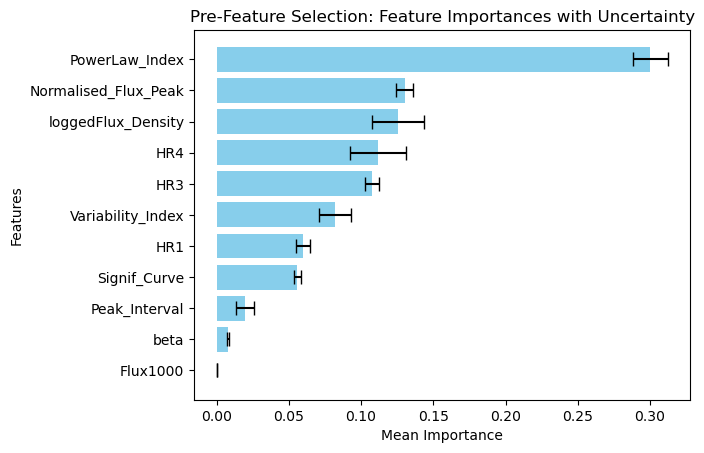

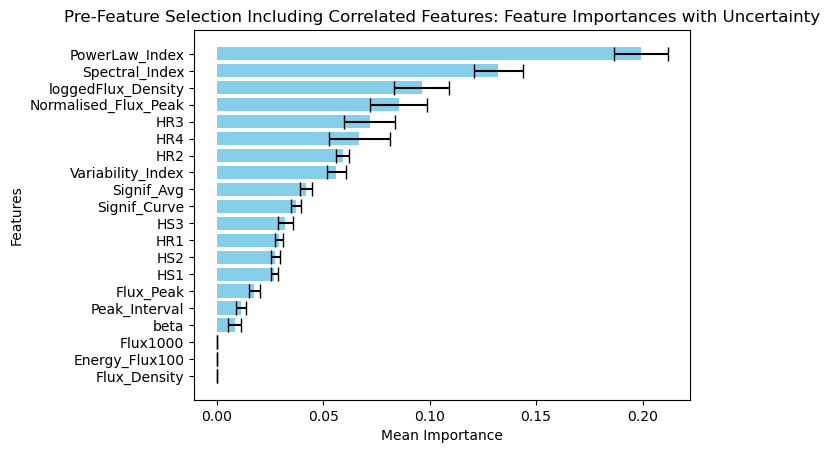

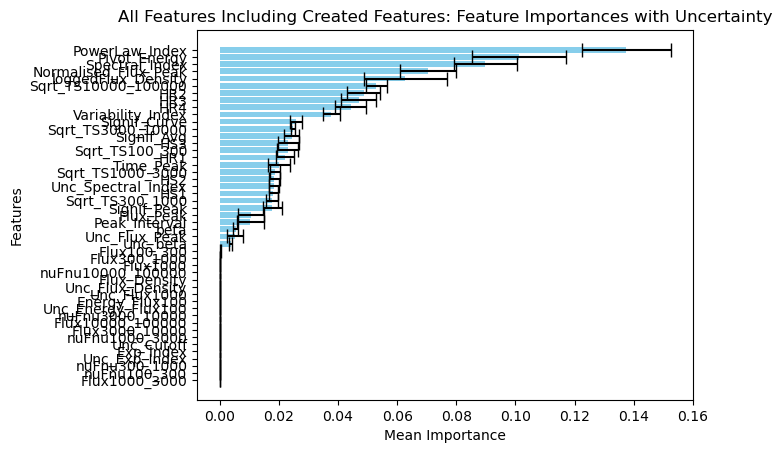

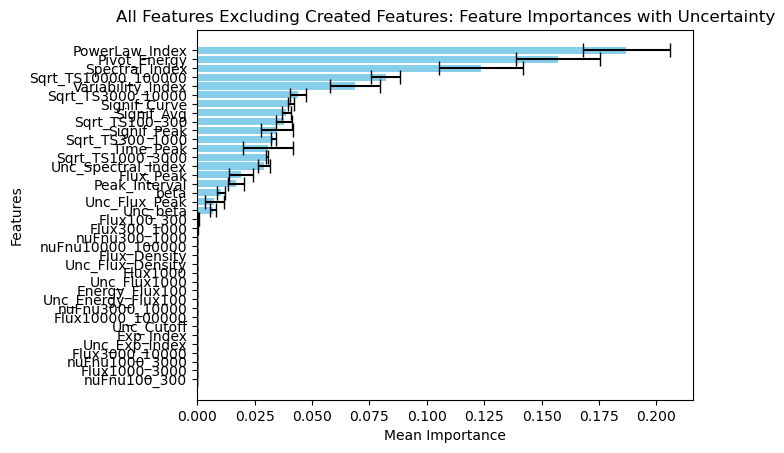

In [150]:
# Feature importances bar graphs
# FULLY FILTERED
sorted_features, sorted_mean_importances, sorted_std_importances = feature_importances(X_fully_filtered_train, y_fully_filtered_train)
plt.barh(sorted_features, sorted_mean_importances, xerr=sorted_std_importances, color='skyblue', capsize=5)
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.title('Pre-Feature Selection: Feature Importances with Uncertainty')
plt.show()

# FEATURES WITH PRELIMINARY REMOVAL, BUT BEFRE CORRELATION MATRIX
sorted_features, sorted_mean_importances, sorted_std_importances = feature_importances(X_including_correlation_train, y_including_correlation_train)
plt.barh(sorted_features, sorted_mean_importances, xerr=sorted_std_importances, color='skyblue', capsize=5)
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.title('Pre-Feature Selection Including Correlated Features: Feature Importances with Uncertainty')
plt.show()

# ALL FEATURES (INCLUDING CREATED)
sorted_features, sorted_mean_importances, sorted_std_importances = feature_importances(X_all_features_train, y_all_features_train)
plt.barh(sorted_features, sorted_mean_importances, xerr=sorted_std_importances, color='skyblue', capsize=5)
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.title('All Features Including Created Features: Feature Importances with Uncertainty')
plt.show()

# ALL FEATURES BUT WITH NO CREATED FEATURES
sorted_features, sorted_mean_importances, sorted_std_importances = feature_importances(X_all_no_created_train, y_all_no_created_train)
plt.barh(sorted_features, sorted_mean_importances, xerr=sorted_std_importances, color='skyblue', capsize=5)
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.title('All Features Excluding Created Features: Feature Importances with Uncertainty')
plt.show()

In [151]:
# Graph number of features vs AUC for feature selection and their errors (scatter plot graph with error bars)
def graph_feature_num_vs_AUC(X_train, y_train, title_prefix, class_label, **rf_params):
    rf = RandomForestClassifier(**rf_params)
    X_train_removing_cols = X_train.copy()
    
    y_array = np.array(y_train)
    label_mapping = {'FSRQ': 0, 'BLL': 1} if class_label == 'BLL' else {'FSRQ': 1, 'BLL': 0}
    y_array_numeric = np.array([label_mapping[label] for label in y_array])


    sorted_features, sorted_mean_importances, sorted_std_importances = feature_importances(X_train_removing_cols, y_train)
    
    features_in_CV = []
    num_features = []
    class_AUC = []
    class_std = []

    # loop through from 1 to the number of features, calculating the auc, and the feature importance 

    for i in range(len(X_train.columns), 0, -1):
        num_features.append(i)
        # do cross validation for AUC
        tprs, aucs = [], []
        mean_fpr = np.linspace(0, 1, 100)
        
        # Set up the cross-validation
        cross_val = KFold(n_splits=5, random_state=42, shuffle=True)

        X_current_features = X_train[sorted_features]
        X_current_features_array = np.array(X_current_features) 

        # Loop through each fold
        for j, (train, test) in enumerate(cross_val.split(X_current_features_array, y_array_numeric)):
            # Fit the model on the training data
            rf.fit(X_current_features_array[train], y_array_numeric[train])
            
            # Predict the probabilities on the test data
            y_proba = rf.predict_proba(X_current_features_array[test])[:, 1]  # Get the probabilities for the positive class
        
            # Calculate the ROC curve and AUC for this fold
            fpr, tpr, _ = roc_curve(y_array_numeric[test], y_proba, pos_label = 1) # Calculate the ROC
            roc_auc = auc(fpr, tpr) # Calculate the AUC
            
            # Interpolate the TPR for a common mean FPR
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0 # making sure that the first value is 0 so that the curve starts at 0 (0% false positive rate and 0% true positive rate)
            tprs.append(interp_tpr)
            aucs.append(roc_auc)
        
        # Find mean AUC and std
        mean_tpr = np.mean(tprs, axis=0) # find the mean tpr
        mean_tpr[-1] = 1.0 # making sure that the last value of mean_tpr = 1
        mean_auc = auc(mean_fpr, mean_tpr) # find the mean AUC
        std_auc = np.std(aucs) # find standard deviation in the AUC
        
        class_AUC.append(mean_auc)
        class_std.append(std_auc)

        # get the new feature importance values
        sorted_features, sorted_mean_importances, sorted_std_importances = feature_importances(X_train_removing_cols, y_train)
        print(f'for {i} features, the important features are {sorted_features}')
        # remove the first (least significant) feature importance value
        sorted_features = sorted_features[1:]
        # print(f'The sorted features are: {(sorted_features)}')
        X_train_removing_cols = X_train_removing_cols[sorted_features]

    # NO MEDIAN LINE AS SOME PLATEAU AT THE VERY BEGINNING
    # reverse_class_AUC =  np.flip(class_AUC)
    # auc_diffs = np.diff(reverse_class_AUC)  # Get differences between consecutive AUC values
    # print(f'auc_diffs is {auc_diffs}')
    # plateau_index = np.where(np.abs(auc_diffs) < 0.005)[0]  # Find where the differences are small (you can adjust the threshold)
    # print(f'plateau_index is {plateau_index}')

    # if len(plateau_index) > 0:
    #     # If a plateau is detected, calculate median AUC after plateau
    #     plateau_start = plateau_index[0] + 1 # Index of the first point after the plateau starts
    #     print(f'plateau_start is {plateau_start}')
    #     auc_after_plateau = reverse_class_AUC[plateau_start:]
    #     print(f'auc_after_plateau is {auc_after_plateau}')
    #     median_after_plateau = np.median(auc_after_plateau)
    #     print(f'median_after_plateau is {median_after_plateau}')
    # else:
    #     # If no clear plateau, default to using the entire range
    #     median_after_plateau = 0
        
    # Plotting
    # median_auc = np.median(class_AUC)
    # plt.axhline(y=median_after_plateau, color='r', linestyle='--', label=f'Median AUC after plateau (auc differs by < 0.01): {median_after_plateau:.2f}')
    plt.errorbar(num_features, class_AUC, yerr=class_std, fmt='o', capsize=5)
    plt.xlabel('Number of Features')
    plt.ylabel(f'{class_label} AUC')
    plt.title(f'{title_prefix}: Number of Features vs {class_label} AUC with Std Error Bars')
    plt.grid(True)
    plt.show()
    return


for 11 features, the important features are ['Flux1000' 'beta' 'Peak_Interval' 'Signif_Curve' 'HR1'
 'Variability_Index' 'HR4' 'HR3' 'Normalised_Flux_Peak'
 'loggedFlux_Density' 'PowerLaw_Index']
for 10 features, the important features are ['beta' 'Peak_Interval' 'Signif_Curve' 'HR1' 'Variability_Index' 'HR3'
 'HR4' 'Normalised_Flux_Peak' 'loggedFlux_Density' 'PowerLaw_Index']
for 9 features, the important features are ['Peak_Interval' 'Signif_Curve' 'HR1' 'Variability_Index' 'HR4' 'HR3'
 'Normalised_Flux_Peak' 'loggedFlux_Density' 'PowerLaw_Index']
for 8 features, the important features are ['Signif_Curve' 'HR1' 'Variability_Index' 'HR4' 'HR3'
 'Normalised_Flux_Peak' 'loggedFlux_Density' 'PowerLaw_Index']
for 7 features, the important features are ['HR1' 'Variability_Index' 'HR4' 'HR3' 'Normalised_Flux_Peak'
 'loggedFlux_Density' 'PowerLaw_Index']
for 6 features, the important features are ['Variability_Index' 'HR3' 'HR4' 'Normalised_Flux_Peak'
 'loggedFlux_Density' 'PowerLaw_Index']


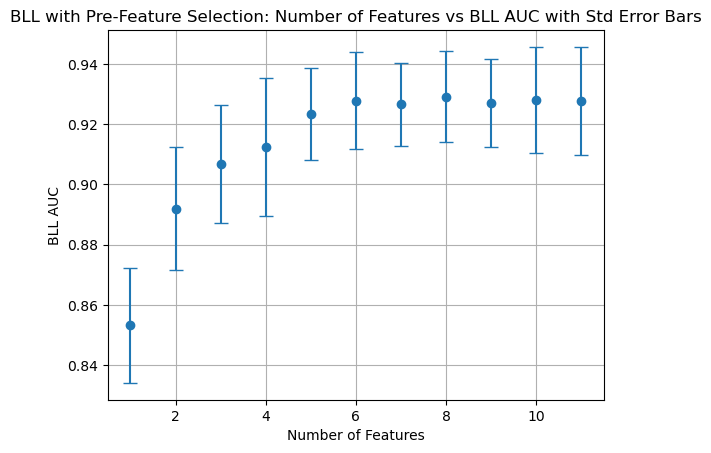

for 11 features, the important features are ['Flux1000' 'beta' 'Peak_Interval' 'Signif_Curve' 'HR1'
 'Variability_Index' 'HR4' 'HR3' 'Normalised_Flux_Peak'
 'loggedFlux_Density' 'PowerLaw_Index']
for 10 features, the important features are ['beta' 'Peak_Interval' 'Signif_Curve' 'HR1' 'Variability_Index' 'HR3'
 'HR4' 'Normalised_Flux_Peak' 'loggedFlux_Density' 'PowerLaw_Index']
for 9 features, the important features are ['Peak_Interval' 'HR1' 'Signif_Curve' 'Variability_Index' 'HR4' 'HR3'
 'loggedFlux_Density' 'Normalised_Flux_Peak' 'PowerLaw_Index']
for 8 features, the important features are ['Signif_Curve' 'HR1' 'Variability_Index' 'HR4' 'HR3'
 'Normalised_Flux_Peak' 'loggedFlux_Density' 'PowerLaw_Index']
for 7 features, the important features are ['HR1' 'Variability_Index' 'HR4' 'HR3' 'Normalised_Flux_Peak'
 'loggedFlux_Density' 'PowerLaw_Index']
for 6 features, the important features are ['Variability_Index' 'HR4' 'HR3' 'Normalised_Flux_Peak'
 'loggedFlux_Density' 'PowerLaw_Index']


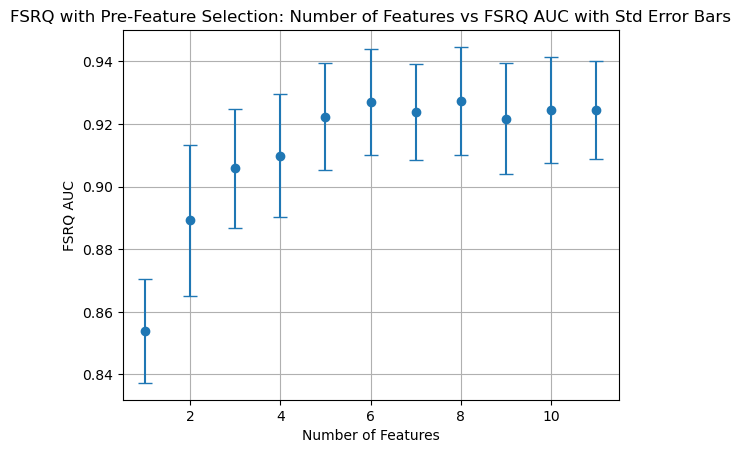

for 20 features, the important features are ['Flux_Density' 'Flux1000' 'Energy_Flux100' 'beta' 'Flux_Peak'
 'Peak_Interval' 'HS1' 'HS2' 'HR1' 'HS3' 'Signif_Curve' 'Signif_Avg'
 'Variability_Index' 'HR2' 'HR4' 'HR3' 'loggedFlux_Density'
 'Normalised_Flux_Peak' 'Spectral_Index' 'PowerLaw_Index']
for 19 features, the important features are ['Energy_Flux100' 'Flux1000' 'beta' 'Peak_Interval' 'Flux_Peak' 'HS1'
 'HS2' 'HR1' 'HS3' 'Signif_Curve' 'Signif_Avg' 'Variability_Index' 'HR2'
 'HR4' 'HR3' 'loggedFlux_Density' 'Normalised_Flux_Peak' 'Spectral_Index'
 'PowerLaw_Index']
for 18 features, the important features are ['Flux1000' 'beta' 'Peak_Interval' 'Flux_Peak' 'HS1' 'HS2' 'HR1' 'HS3'
 'Signif_Curve' 'Signif_Avg' 'Variability_Index' 'HR4' 'HR2' 'HR3'
 'Normalised_Flux_Peak' 'loggedFlux_Density' 'Spectral_Index'
 'PowerLaw_Index']
for 17 features, the important features are ['beta' 'Flux_Peak' 'Peak_Interval' 'HS1' 'HS2' 'HR1' 'HS3' 'Signif_Curve'
 'Signif_Avg' 'Variability_Index' 'HR2' 'HR

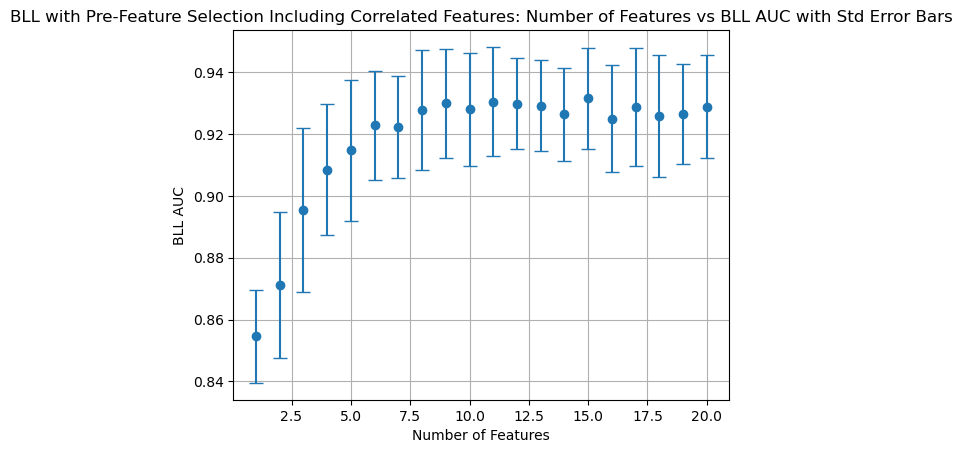

for 20 features, the important features are ['Flux_Density' 'Flux1000' 'Energy_Flux100' 'beta' 'Peak_Interval'
 'Flux_Peak' 'HS2' 'HS1' 'HR1' 'HS3' 'Signif_Curve' 'Signif_Avg'
 'Variability_Index' 'HR2' 'HR4' 'HR3' 'Normalised_Flux_Peak'
 'loggedFlux_Density' 'Spectral_Index' 'PowerLaw_Index']
for 19 features, the important features are ['Flux1000' 'Energy_Flux100' 'beta' 'Flux_Peak' 'Peak_Interval' 'HS1'
 'HS2' 'HR1' 'HS3' 'Signif_Curve' 'Signif_Avg' 'Variability_Index' 'HR2'
 'HR4' 'HR3' 'loggedFlux_Density' 'Normalised_Flux_Peak' 'Spectral_Index'
 'PowerLaw_Index']
for 18 features, the important features are ['Energy_Flux100' 'beta' 'Peak_Interval' 'Flux_Peak' 'HS1' 'HR1' 'HS2'
 'HS3' 'Signif_Curve' 'Signif_Avg' 'Variability_Index' 'HR4' 'HR2' 'HR3'
 'loggedFlux_Density' 'Normalised_Flux_Peak' 'Spectral_Index'
 'PowerLaw_Index']
for 17 features, the important features are ['beta' 'Peak_Interval' 'Flux_Peak' 'HS1' 'HS2' 'HR1' 'HS3' 'Signif_Curve'
 'Signif_Avg' 'HR4' 'Variability_Inde

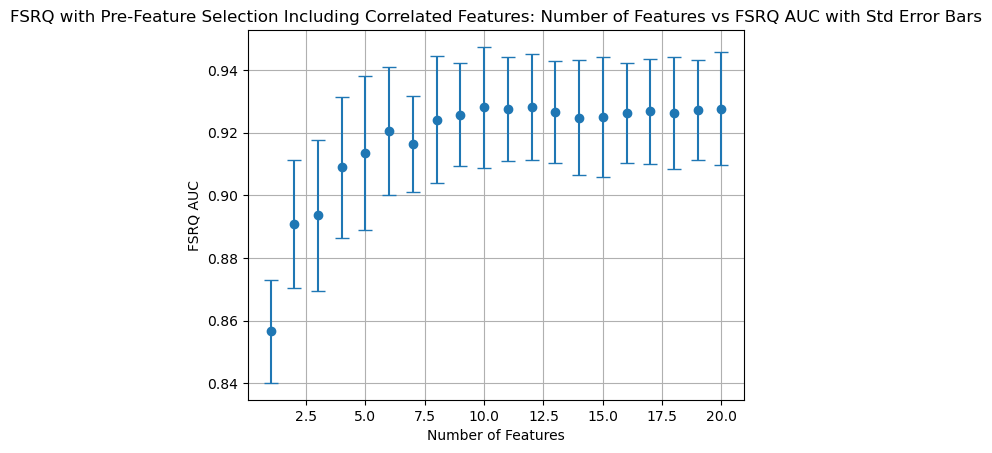

for 47 features, the important features are ['Flux1000_3000' 'Unc_Exp_Index' 'Exp_Index' 'Unc_Cutoff' 'nuFnu300_1000'
 'nuFnu1000_3000' 'Flux3000_10000' 'nuFnu3000_10000' 'Flux10000_100000'
 'Unc_Energy_Flux100' 'Energy_Flux100' 'Unc_Flux1000' 'Flux1000'
 'Unc_Flux_Density' 'Flux_Density' 'nuFnu10000_100000' 'nuFnu100_300'
 'Flux300_1000' 'Flux100_300' 'Unc_beta' 'beta' 'Unc_Flux_Peak'
 'Peak_Interval' 'Flux_Peak' 'Signif_Peak' 'Time_Peak' 'HS1'
 'Unc_Spectral_Index' 'Sqrt_TS1000_3000' 'Sqrt_TS300_1000'
 'Sqrt_TS100_300' 'HS2' 'HR1' 'HS3' 'Signif_Curve' 'Signif_Avg'
 'Sqrt_TS3000_10000' 'HR4' 'Variability_Index' 'HR2' 'HR3'
 'Sqrt_TS10000_100000' 'loggedFlux_Density' 'Normalised_Flux_Peak'
 'Spectral_Index' 'Pivot_Energy' 'PowerLaw_Index']
for 46 features, the important features are ['Unc_Exp_Index' 'nuFnu100_300' 'nuFnu10000_100000' 'Flux_Density'
 'Unc_Flux_Density' 'Flux1000' 'Energy_Flux100' 'Unc_Energy_Flux100'
 'Unc_Flux1000' 'nuFnu3000_10000' 'Flux3000_10000' 'nuFnu1000_3000'
 '

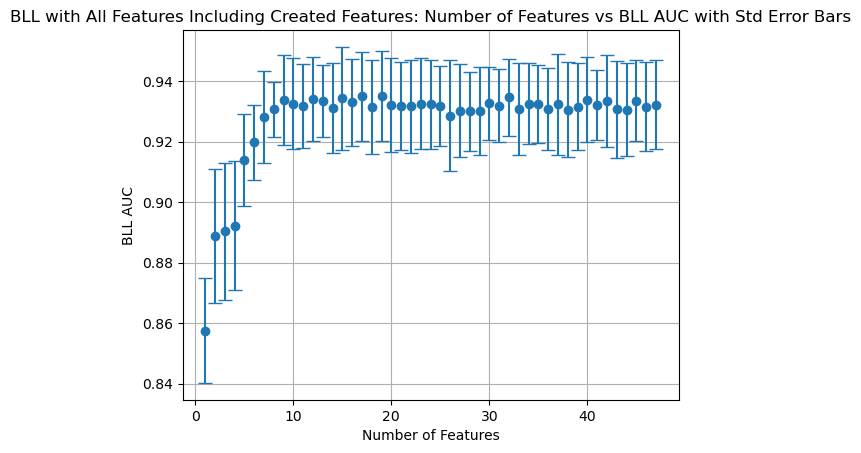

for 47 features, the important features are ['Flux1000_3000' 'Unc_Exp_Index' 'Exp_Index' 'Unc_Cutoff' 'nuFnu300_1000'
 'nuFnu1000_3000' 'Flux3000_10000' 'nuFnu3000_10000' 'Flux10000_100000'
 'Unc_Energy_Flux100' 'Energy_Flux100' 'Unc_Flux1000' 'Flux1000'
 'Unc_Flux_Density' 'Flux_Density' 'nuFnu10000_100000' 'nuFnu100_300'
 'Flux300_1000' 'Flux100_300' 'Unc_beta' 'Unc_Flux_Peak' 'beta'
 'Flux_Peak' 'Peak_Interval' 'Sqrt_TS1000_3000' 'Unc_Spectral_Index' 'HS1'
 'HS2' 'Signif_Peak' 'Sqrt_TS300_1000' 'Time_Peak' 'HR1' 'HS3'
 'Signif_Curve' 'Sqrt_TS100_300' 'Signif_Avg' 'Sqrt_TS3000_10000'
 'Variability_Index' 'HR2' 'HR3' 'HR4' 'Sqrt_TS10000_100000'
 'loggedFlux_Density' 'Normalised_Flux_Peak' 'Spectral_Index'
 'Pivot_Energy' 'PowerLaw_Index']
for 46 features, the important features are ['Unc_Exp_Index' 'nuFnu100_300' 'nuFnu10000_100000' 'Flux_Density'
 'Unc_Flux_Density' 'Flux1000' 'Energy_Flux100' 'Unc_Energy_Flux100'
 'Unc_Flux1000' 'nuFnu3000_10000' 'Flux3000_10000' 'nuFnu1000_3000'
 '

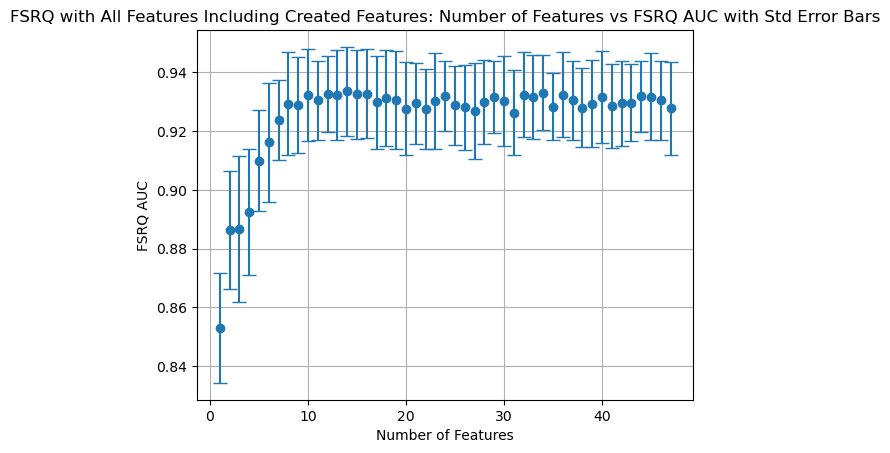

for 38 features, the important features are ['nuFnu100_300' 'Flux1000_3000' 'nuFnu1000_3000' 'Flux3000_10000'
 'Unc_Exp_Index' 'Exp_Index' 'Unc_Cutoff' 'Flux10000_100000'
 'nuFnu3000_10000' 'Unc_Energy_Flux100' 'Energy_Flux100' 'Unc_Flux1000'
 'Flux1000' 'Unc_Flux_Density' 'Flux_Density' 'nuFnu10000_100000'
 'nuFnu300_1000' 'Flux300_1000' 'Flux100_300' 'Unc_Flux_Peak' 'Unc_beta'
 'beta' 'Peak_Interval' 'Flux_Peak' 'Time_Peak' 'Unc_Spectral_Index'
 'Sqrt_TS1000_3000' 'Sqrt_TS300_1000' 'Signif_Peak' 'Signif_Avg'
 'Sqrt_TS100_300' 'Signif_Curve' 'Sqrt_TS3000_10000' 'Variability_Index'
 'Sqrt_TS10000_100000' 'Spectral_Index' 'Pivot_Energy' 'PowerLaw_Index']
for 37 features, the important features are ['Flux1000_3000' 'nuFnu300_1000' 'nuFnu10000_100000' 'Flux_Density'
 'Unc_Flux_Density' 'Unc_Flux1000' 'Unc_Energy_Flux100' 'Energy_Flux100'
 'Flux10000_100000' 'Unc_Cutoff' 'Exp_Index' 'Unc_Exp_Index'
 'Flux3000_10000' 'nuFnu1000_3000' 'nuFnu3000_10000' 'Flux1000'
 'Flux300_1000' 'Flux100_300

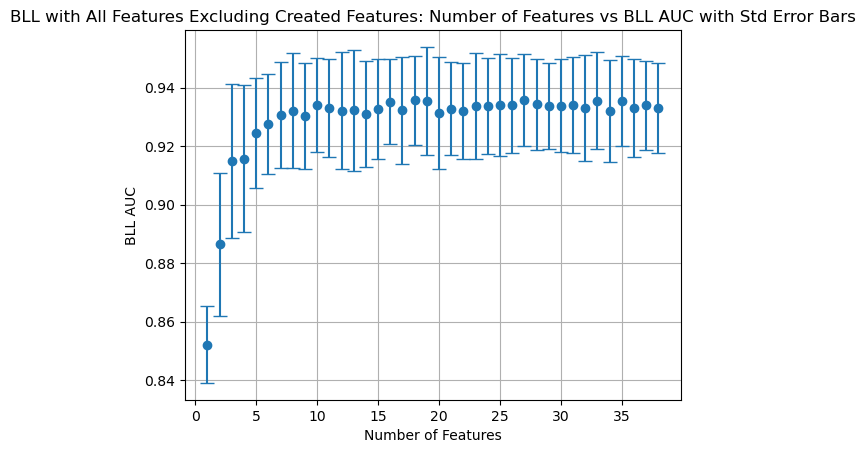

for 38 features, the important features are ['nuFnu100_300' 'nuFnu1000_3000' 'Flux3000_10000' 'nuFnu3000_10000'
 'Unc_Exp_Index' 'Exp_Index' 'Unc_Cutoff' 'nuFnu300_1000'
 'Flux10000_100000' 'Flux1000_3000' 'Unc_Energy_Flux100' 'Energy_Flux100'
 'Unc_Flux1000' 'Flux1000' 'Unc_Flux_Density' 'Flux_Density'
 'nuFnu10000_100000' 'Flux300_1000' 'Flux100_300' 'Unc_Flux_Peak'
 'Unc_beta' 'beta' 'Flux_Peak' 'Peak_Interval' 'Unc_Spectral_Index'
 'Signif_Peak' 'Sqrt_TS1000_3000' 'Sqrt_TS300_1000' 'Time_Peak'
 'Sqrt_TS100_300' 'Signif_Avg' 'Signif_Curve' 'Sqrt_TS3000_10000'
 'Variability_Index' 'Sqrt_TS10000_100000' 'Spectral_Index' 'Pivot_Energy'
 'PowerLaw_Index']
for 37 features, the important features are ['nuFnu1000_3000' 'nuFnu10000_100000' 'Flux_Density' 'Unc_Flux_Density'
 'Unc_Flux1000' 'Energy_Flux100' 'Flux1000_3000' 'Unc_Energy_Flux100'
 'nuFnu300_1000' 'Unc_Cutoff' 'Exp_Index' 'Unc_Exp_Index'
 'nuFnu3000_10000' 'Flux3000_10000' 'Flux10000_100000' 'Flux1000'
 'Flux300_1000' 'Flux100_30

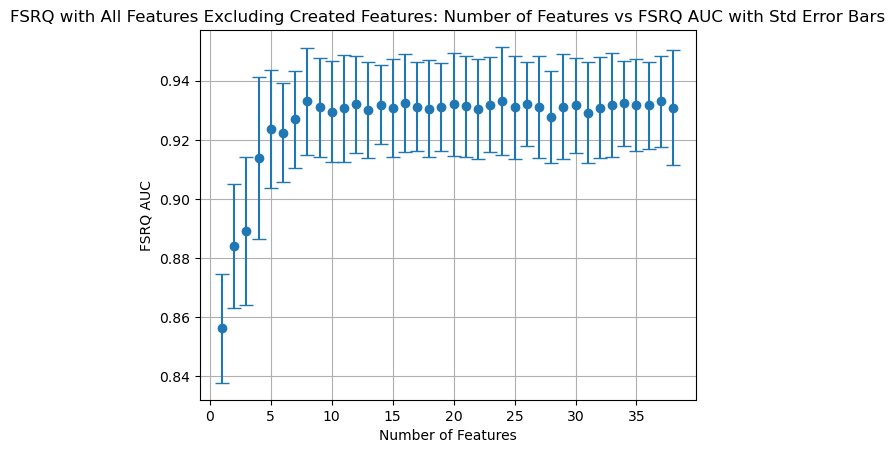

In [152]:
# # FULLY FILTERED
graph_feature_num_vs_AUC(X_fully_filtered_train, y_fully_filtered_train, title_prefix="BLL with Pre-Feature Selection", class_label = 'BLL')
graph_feature_num_vs_AUC(X_fully_filtered_train, y_fully_filtered_train, title_prefix="FSRQ with Pre-Feature Selection", class_label = 'FSRQ')

# # FEATURES WITH PRELIMINARY REMOVAL, BUT BEFRE CORRELATION MATRIX
graph_feature_num_vs_AUC(X_including_correlation_train, y_including_correlation_train, title_prefix='BLL with Pre-Feature Selection Including Correlated Features', class_label = 'BLL')
graph_feature_num_vs_AUC(X_including_correlation_train, y_including_correlation_train, title_prefix='FSRQ with Pre-Feature Selection Including Correlated Features', class_label = 'FSRQ')

# ALL FEATURES (INCLUDING CREATED)
graph_feature_num_vs_AUC(X_all_features_train, y_all_features_train, title_prefix='BLL with All Features Including Created Features', class_label = 'BLL')
graph_feature_num_vs_AUC(X_all_features_train, y_all_features_train, title_prefix='FSRQ with All Features Including Created Features', class_label = 'FSRQ')

# ALL FEATURES BUT WITH NO CREATED FEATURES
graph_feature_num_vs_AUC(X_all_no_created_train, y_all_no_created_train, title_prefix='BLL with All Features Excluding Created Features', class_label = 'BLL')
graph_feature_num_vs_AUC(X_all_no_created_train, y_all_no_created_train, title_prefix='FSRQ with All Features Excluding Created Features', class_label = 'FSRQ')

In [239]:
# graph the hyperparameters
def graph_hyperparameter_vs_AUC(X_train, y_train, X_test, y_test, title_prefix, hyper_parameter_array, hyper_parameter_name):
    BLL_train_results = []
    FSRQ_train_results = []
    test_results = []

    X_array = np.array(X_train)
    y_array = np.array(y_train)
    X_array_test = np.array(X_test)
    y_array_test = np.array(y_test)

    for hyperparameter in hyper_parameter_array:
        
        rf = RandomForestClassifier(**{hyper_parameter_name: hyperparameter}, random_state=42)
        rf.fit(X_array, y_array)

        # BLL
        BLL_y_proba = rf.predict_proba(X_array_test)[:, 0]
        BLL_fpr, BLL_tpr, _ = roc_curve(y_array_test, BLL_y_proba, pos_label='BLL')
        BLL_roc_auc = auc(BLL_fpr, BLL_tpr) # Calculate the AUC
        BLL_train_results.append(BLL_roc_auc)

        # FSRQ
        FSRQ_y_proba = rf.predict_proba(X_array_test)[:, 1]
        FSRQ_fpr, FSRQ_tpr, _ = roc_curve(y_array_test, FSRQ_y_proba, pos_label='FSRQ')
        FSRQ_roc_auc = auc(FSRQ_fpr, FSRQ_tpr) # Calculate the AUC
        FSRQ_train_results.append(FSRQ_roc_auc)




    plt.scatter(hyper_parameter_array, BLL_train_results, color='blue', alpha=0.3, label='BLL AUC')
    plt.scatter(hyper_parameter_array, FSRQ_train_results, color='red', alpha=0.3, label='FSRQ AUC')
    plt.title(f'{title_prefix}: AUC vs. {hyper_parameter_name}')
    plt.xlabel(f'{hyper_parameter_name}')
    plt.ylabel('AUC')
    plt.legend()
    plt.grid(True)
    plt.show()

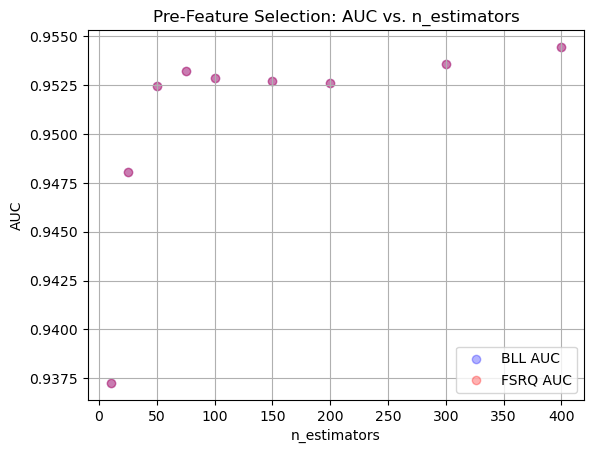

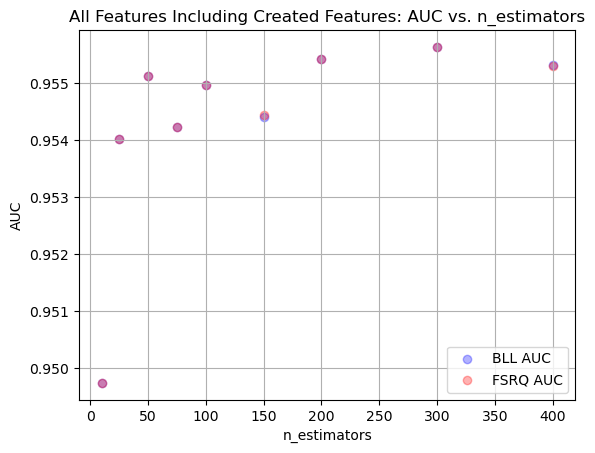

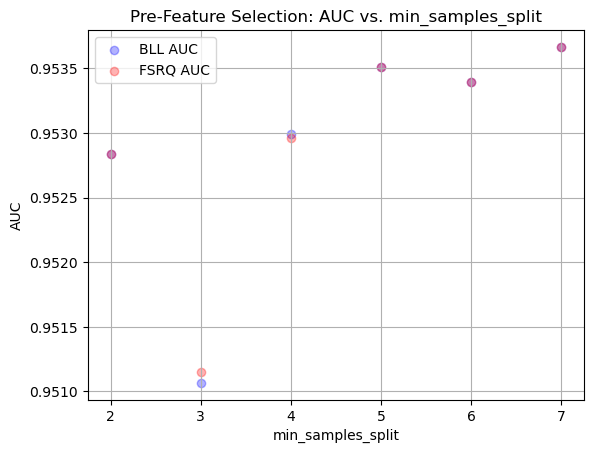

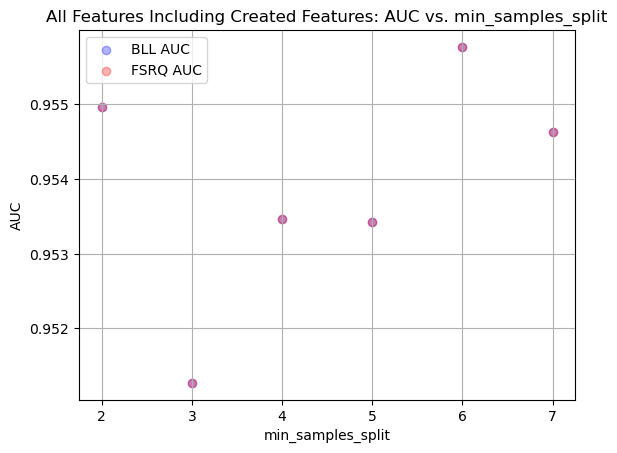

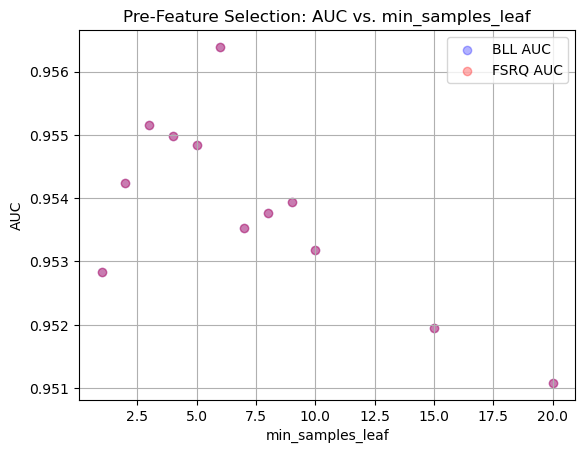

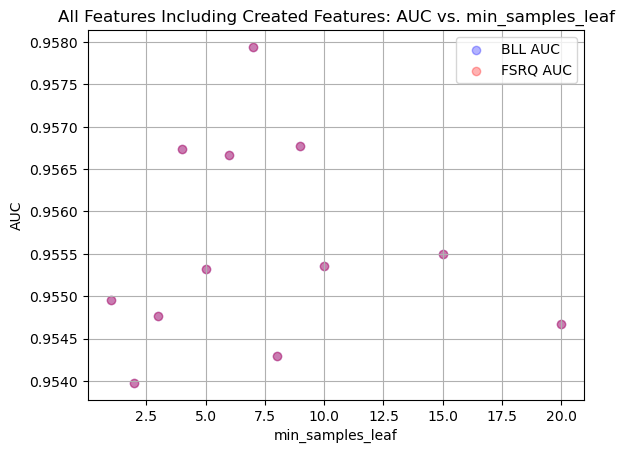

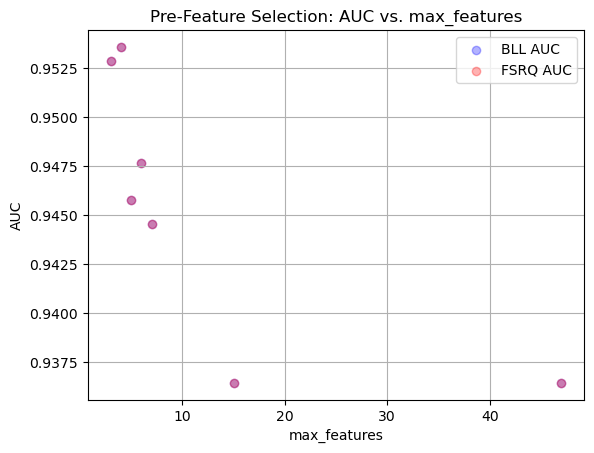

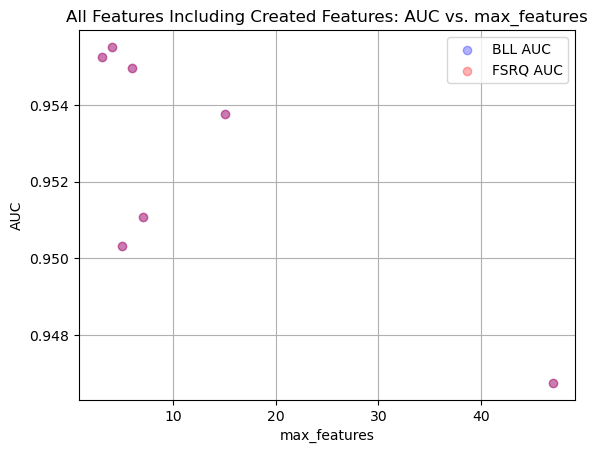

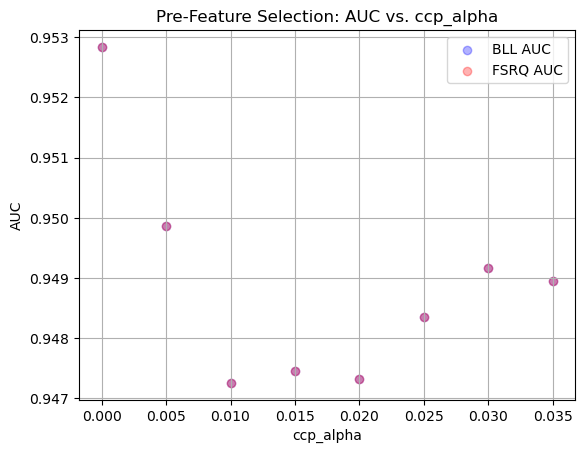

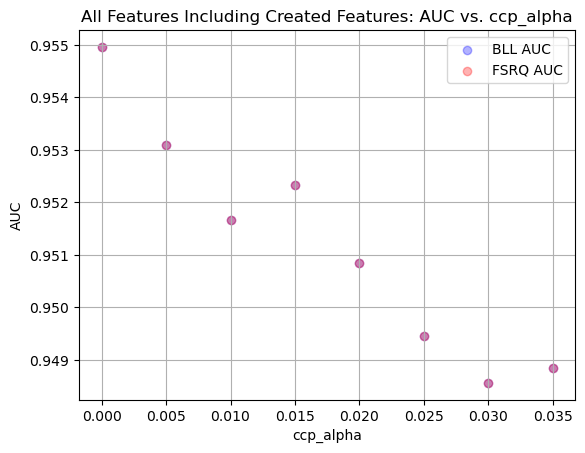

In [240]:
# Define the datasets and their corresponding titles
datasets = [
    (X_fully_filtered_train, y_fully_filtered_train, X_fully_filtered_test, y_fully_filtered_test, "Pre-Feature Selection"),
    (X_all_features_train, y_all_features_train, X_all_features_test, y_all_features_test, 'All Features Including Created Features'),
    ]

# Define hyperparameters to test
hyperparameters = {
    'n_estimators': [10, 25, 50, 75, 100, 150, 200, 300, 400],        # Number of trees
    'min_samples_split': [2, 3, 4, 5, 6, 7],     # from https://www.geeksforgeeks.org/hyperparameters-of-random-forest-classifier/, it generally ranges between 2 and 6
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20] ,         # Minimum samples in a leaf
    'max_features': [3, 4, 5, 6, 7, 15, 47], # sqrt(11) = 3.3, sqrt(47) = 6.8, log2(11) = 3.5, log2(47) = 5.5, None is the max number of features (e.g. 15 and 47)
    'ccp_alpha': [0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035]
}

# Loop through each dataset and each hyperparameter
for hyper_parameter_name, hyper_parameter_array in hyperparameters.items():
    for X_train, y_train, X_test, y_test, title_prefix, in datasets:
        graph_hyperparameter_vs_AUC(
            X_train, y_train, X_test, y_test,
            title_prefix=title_prefix,
            hyper_parameter_array=hyper_parameter_array,
            hyper_parameter_name=hyper_parameter_name
        )


for 11 features, the important features are ['Flux1000' 'beta' 'Peak_Interval' 'HR1' 'Signif_Curve'
 'Variability_Index' 'HR4' 'HR3' 'Normalised_Flux_Peak'
 'loggedFlux_Density' 'PowerLaw_Index']
for 10 features, the important features are ['beta' 'Peak_Interval' 'Signif_Curve' 'HR1' 'Variability_Index' 'HR4'
 'HR3' 'loggedFlux_Density' 'Normalised_Flux_Peak' 'PowerLaw_Index']
for 9 features, the important features are ['Peak_Interval' 'Signif_Curve' 'HR1' 'Variability_Index' 'HR4' 'HR3'
 'Normalised_Flux_Peak' 'loggedFlux_Density' 'PowerLaw_Index']
for 8 features, the important features are ['Signif_Curve' 'HR1' 'Variability_Index' 'HR3' 'HR4'
 'Normalised_Flux_Peak' 'loggedFlux_Density' 'PowerLaw_Index']
for 7 features, the important features are ['HR1' 'Variability_Index' 'HR4' 'HR3' 'Normalised_Flux_Peak'
 'loggedFlux_Density' 'PowerLaw_Index']
for 6 features, the important features are ['Variability_Index' 'HR4' 'HR3' 'Normalised_Flux_Peak'
 'loggedFlux_Density' 'PowerLaw_Index']


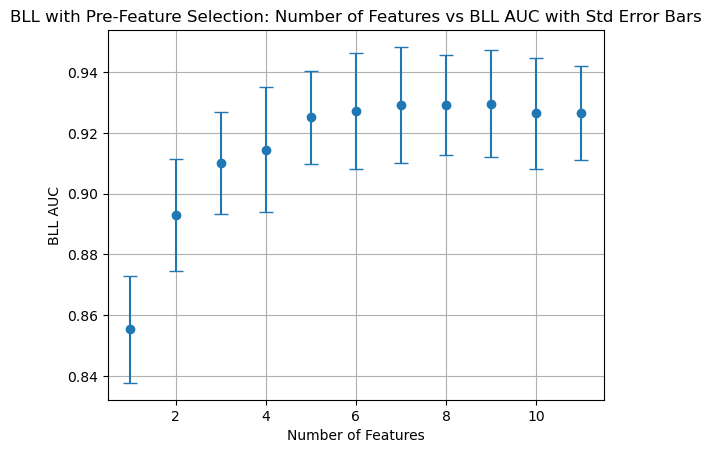

for 11 features, the important features are ['Flux1000' 'beta' 'Peak_Interval' 'Signif_Curve' 'HR1'
 'Variability_Index' 'HR4' 'HR3' 'Normalised_Flux_Peak'
 'loggedFlux_Density' 'PowerLaw_Index']
for 10 features, the important features are ['beta' 'Peak_Interval' 'Signif_Curve' 'HR1' 'Variability_Index' 'HR3'
 'HR4' 'Normalised_Flux_Peak' 'loggedFlux_Density' 'PowerLaw_Index']
for 9 features, the important features are ['Peak_Interval' 'Signif_Curve' 'HR1' 'Variability_Index' 'HR4' 'HR3'
 'Normalised_Flux_Peak' 'loggedFlux_Density' 'PowerLaw_Index']
for 8 features, the important features are ['Signif_Curve' 'HR1' 'Variability_Index' 'HR4' 'HR3'
 'Normalised_Flux_Peak' 'loggedFlux_Density' 'PowerLaw_Index']
for 7 features, the important features are ['HR1' 'Variability_Index' 'HR4' 'HR3' 'Normalised_Flux_Peak'
 'loggedFlux_Density' 'PowerLaw_Index']
for 6 features, the important features are ['Variability_Index' 'HR4' 'HR3' 'Normalised_Flux_Peak'
 'loggedFlux_Density' 'PowerLaw_Index']


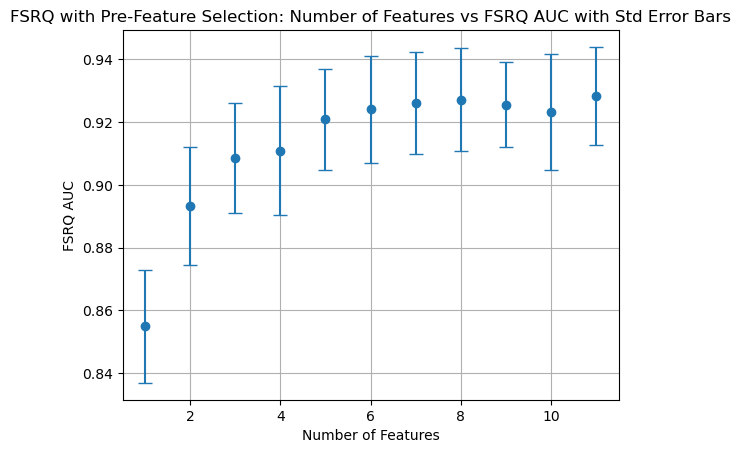

In [155]:
# # FULLY FILTERED, graphing with hyper parameter tuning

graph_feature_num_vs_AUC(X_fully_filtered_train, y_fully_filtered_train, title_prefix="BLL with Pre-Feature Selection", class_label = 'BLL', n_estimators=150)
graph_feature_num_vs_AUC(X_fully_filtered_train, y_fully_filtered_train, title_prefix="FSRQ with Pre-Feature Selection", class_label = 'FSRQ', n_estimators=150)


In [156]:
# hyperparameter tuning
def hyperParameterTuning_randomSearch(X_train, y_train, param_grid):
    rf = RandomForestClassifier()
    random_search = RandomizedSearchCV(rf, param_distributions=param_grid,
                        n_iter=10, scoring="roc_auc", random_state=42,
                        n_jobs=-1, cv=5, return_train_score=True)

    X_fully_filtered_train_array = np.array(X_train)
    y_fully_filtered_train_array = np.array(y_train)
    
    
    BLL_label_mapping = {'FSRQ': 0, 'BLL': 1}
    BLL_y_array_numeric = np.array([BLL_label_mapping[label] for label in y_fully_filtered_train_array])
    
    FSRQ_label_mapping = {'FSRQ': 1, 'BLL': 0}
    FSRQ_y_array_numeric = np.array([FSRQ_label_mapping[label] for label in y_fully_filtered_train_array])
    
    
    random_search.fit(X_fully_filtered_train_array, y_fully_filtered_train_array)
    print("RF: Optimal hyperparameter combination:", random_search.best_params_)
    print("RF: Mean cross-validated training AUC score:",  random_search.best_score_)
    print()
    
    random_search.fit(X_fully_filtered_train_array, BLL_y_array_numeric)
    print("BLL: Optimal hyperparameter combination:", random_search.best_params_)
    print("BLL: Mean cross-validated training AUC score:",  random_search.best_score_)
    print()
    
    random_search.fit(X_fully_filtered_train_array, FSRQ_y_array_numeric)
    print("FSRQ: Optimal hyperparameter combination:", random_search.best_params_)
    print("FSRQ: Mean cross-validated training AUC score:",  random_search.best_score_)
    print()


In [170]:
# hyperparameter tuning
def hyperParameterTuning_gridSearch(X_train, y_train, param_grid):
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(rf, param_grid=param_grid, scoring="roc_auc", cv=5, return_train_score=True)

    X_fully_filtered_train_array = np.array(X_train)
    y_fully_filtered_train_array = np.array(y_train)
    
    
    BLL_label_mapping = {'FSRQ': 0, 'BLL': 1}
    BLL_y_array_numeric = np.array([BLL_label_mapping[label] for label in y_fully_filtered_train_array])
    
    FSRQ_label_mapping = {'FSRQ': 1, 'BLL': 0}
    FSRQ_y_array_numeric = np.array([FSRQ_label_mapping[label] for label in y_fully_filtered_train_array])
    
    
    grid_search.fit(X_fully_filtered_train_array, y_fully_filtered_train_array)
    print("RF: Optimal hyperparameter combination:", grid_search.best_params_)
    print("RF: Mean cross-validated training AUC score:",  grid_search.best_score_)
    print()
    
    grid_search.fit(X_fully_filtered_train_array, BLL_y_array_numeric)
    print("BLL: Optimal hyperparameter combination:", grid_search.best_params_)
    print("BLL: Mean cross-validated training AUC score:",  grid_search.best_score_)
    print()
    
    grid_search.fit(X_fully_filtered_train_array, FSRQ_y_array_numeric)
    print("FSRQ: Optimal hyperparameter combination:", grid_search.best_params_)
    print("FSRQ: Mean cross-validated training AUC score:",  grid_search.best_score_)
    print()


In [158]:
param_grid1 = {
    'n_estimators': [150],        # Number of trees
    'min_samples_split': [2, 3, 4, 5, 6, 7],     # from https://www.geeksforgeeks.org/hyperparameters-of-random-forest-classifier/, it generally ranges between 2 and 6
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20] ,         # Minimum samples in a leaf
    'max_features': ['sqrt', 'log2', None], # Number of features to consider when looking for the best split https://www.geeksforgeeks.org/hyperparameters-of-random-forest-classifier/
    'bootstrap': [True, False],
    'ccp_alpha': [0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035]
}

hyperParameterTuning_randomSearch(X_fully_filtered_train, y_fully_filtered_train, param_grid1)

RF: Optimal hyperparameter combination: {'n_estimators': 150, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'ccp_alpha': 0.01, 'bootstrap': True}
RF: Mean cross-validated training AUC score: 0.933892703896572

BLL: Optimal hyperparameter combination: {'n_estimators': 150, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'ccp_alpha': 0.01, 'bootstrap': True}
BLL: Mean cross-validated training AUC score: 0.9331262742060673

FSRQ: Optimal hyperparameter combination: {'n_estimators': 150, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'ccp_alpha': 0.01, 'bootstrap': True}
FSRQ: Mean cross-validated training AUC score: 0.9322107236690075



In [159]:
param_grid2 = {
    'n_estimators': [150],        # Number of trees
    'min_samples_split': [2, 3, 4, 5, 6], 
    'min_samples_leaf': [5, 6, 7, 8, 9, 10, 11] ,         # Minimum samples in a leaf
    'max_features': ['sqrt', 'log2'], # Number of features to consider when looking for the best split https://www.geeksforgeeks.org/hyperparameters-of-random-forest-classifier/
    'bootstrap': [True],
    'ccp_alpha': [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035]
}
hyperParameterTuning_randomSearch(X_fully_filtered_train, y_fully_filtered_train, param_grid2)

RF: Optimal hyperparameter combination: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 11, 'max_features': 'sqrt', 'ccp_alpha': 0.005, 'bootstrap': True}
RF: Mean cross-validated training AUC score: 0.9329767044244169

BLL: Optimal hyperparameter combination: {'n_estimators': 150, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'ccp_alpha': 0.01, 'bootstrap': True}
BLL: Mean cross-validated training AUC score: 0.9331570249774147

FSRQ: Optimal hyperparameter combination: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 11, 'max_features': 'sqrt', 'ccp_alpha': 0.005, 'bootstrap': True}
FSRQ: Mean cross-validated training AUC score: 0.9325148810440004



In [161]:
param_grid3 = {
    'n_estimators': [150],        # Number of trees
    'min_samples_split': [4, 5, 6, 7, 8],     # from https://www.geeksforgeeks.org/hyperparameters-of-random-forest-classifier/, it generally ranges between 2 and 6
    'min_samples_leaf': [7, 8, 9, 10, 11] ,         # Minimum samples in a leaf
    'max_features': ['sqrt'], # Number of features to consider when looking for the best split https://www.geeksforgeeks.org/hyperparameters-of-random-forest-classifier/
    'bootstrap': [True],
    'ccp_alpha': [0, 0.005, 0.01, 0.015]
}
hyperParameterTuning_randomSearch(X_fully_filtered_train, y_fully_filtered_train, param_grid3)

RF: Optimal hyperparameter combination: {'n_estimators': 150, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'ccp_alpha': 0, 'bootstrap': True}
RF: Mean cross-validated training AUC score: 0.9365706068699484

BLL: Optimal hyperparameter combination: {'n_estimators': 150, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'ccp_alpha': 0, 'bootstrap': True}
BLL: Mean cross-validated training AUC score: 0.9375271208104351

FSRQ: Optimal hyperparameter combination: {'n_estimators': 150, 'min_samples_split': 6, 'min_samples_leaf': 11, 'max_features': 'sqrt', 'ccp_alpha': 0, 'bootstrap': True}
FSRQ: Mean cross-validated training AUC score: 0.9371137003293081



for 11 features, the important features are ['Flux1000' 'beta' 'Peak_Interval' 'Signif_Curve' 'HR1'
 'Variability_Index' 'HR4' 'HR3' 'Normalised_Flux_Peak'
 'loggedFlux_Density' 'PowerLaw_Index']
for 10 features, the important features are ['beta' 'Peak_Interval' 'HR1' 'Signif_Curve' 'Variability_Index' 'HR3'
 'HR4' 'Normalised_Flux_Peak' 'loggedFlux_Density' 'PowerLaw_Index']
for 9 features, the important features are ['Peak_Interval' 'HR1' 'Signif_Curve' 'Variability_Index' 'HR4' 'HR3'
 'loggedFlux_Density' 'Normalised_Flux_Peak' 'PowerLaw_Index']
for 8 features, the important features are ['Signif_Curve' 'HR1' 'Variability_Index' 'HR3' 'HR4'
 'Normalised_Flux_Peak' 'loggedFlux_Density' 'PowerLaw_Index']
for 7 features, the important features are ['HR1' 'Variability_Index' 'HR3' 'HR4' 'Normalised_Flux_Peak'
 'loggedFlux_Density' 'PowerLaw_Index']
for 6 features, the important features are ['Variability_Index' 'HR4' 'HR3' 'Normalised_Flux_Peak'
 'loggedFlux_Density' 'PowerLaw_Index']


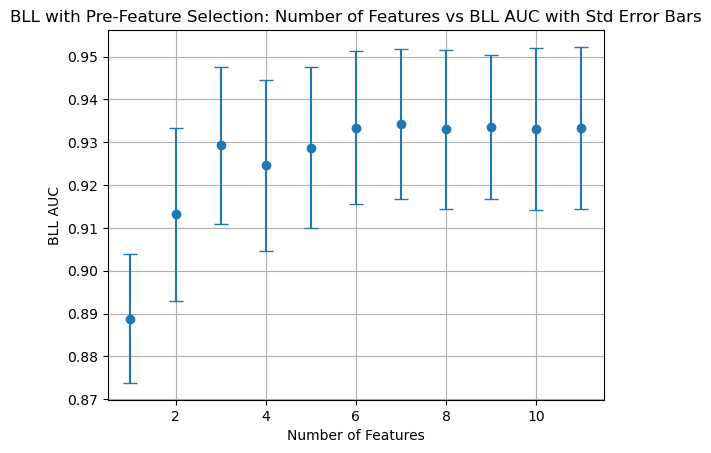

for 11 features, the important features are ['Flux1000' 'beta' 'Peak_Interval' 'Signif_Curve' 'HR1'
 'Variability_Index' 'HR3' 'HR4' 'Normalised_Flux_Peak'
 'loggedFlux_Density' 'PowerLaw_Index']
for 10 features, the important features are ['beta' 'Peak_Interval' 'Signif_Curve' 'HR1' 'Variability_Index' 'HR4'
 'HR3' 'loggedFlux_Density' 'Normalised_Flux_Peak' 'PowerLaw_Index']
for 9 features, the important features are ['Peak_Interval' 'HR1' 'Signif_Curve' 'Variability_Index' 'HR4' 'HR3'
 'loggedFlux_Density' 'Normalised_Flux_Peak' 'PowerLaw_Index']
for 8 features, the important features are ['Signif_Curve' 'HR1' 'Variability_Index' 'HR4' 'HR3'
 'Normalised_Flux_Peak' 'loggedFlux_Density' 'PowerLaw_Index']
for 7 features, the important features are ['HR1' 'Variability_Index' 'HR4' 'HR3' 'Normalised_Flux_Peak'
 'loggedFlux_Density' 'PowerLaw_Index']
for 6 features, the important features are ['Variability_Index' 'HR3' 'HR4' 'Normalised_Flux_Peak'
 'loggedFlux_Density' 'PowerLaw_Index']


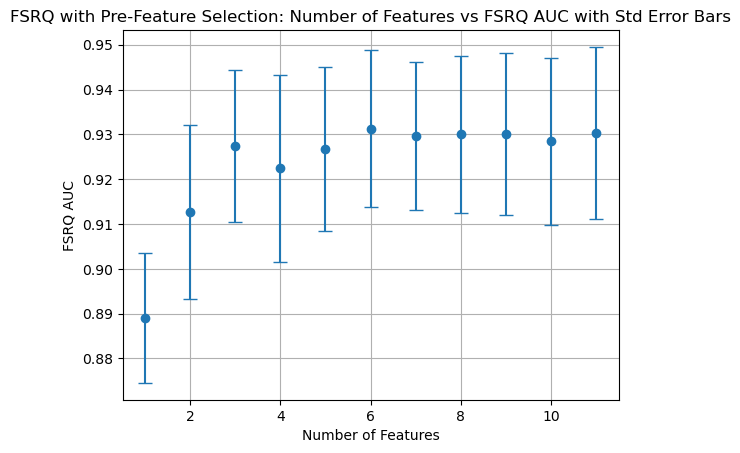

In [162]:
# # FULLY FILTERED, graphing with 2nd hyper parameter tuning
graph_feature_num_vs_AUC(X_fully_filtered_train, y_fully_filtered_train, title_prefix="BLL with Pre-Feature Selection", class_label = 'BLL', n_estimators=150, min_samples_split=4, min_samples_leaf=7, max_features='sqrt', ccp_alpha=0)
graph_feature_num_vs_AUC(X_fully_filtered_train, y_fully_filtered_train, title_prefix="FSRQ with Pre-Feature Selection", class_label = 'FSRQ', n_estimators=150, min_samples_split=4, min_samples_leaf=7, max_features='sqrt', ccp_alpha=0)


In [163]:
seven_features = ['HR1', 'Variability_Index', 'HR4', 'HR3', 'loggedFlux_Density', 'Normalised_Flux_Peak', 'PowerLaw_Index']

X_seven_feature_train = X_fully_filtered_train[seven_features]
y_seven_feature_train = y_fully_filtered_train

X_seven_feature_test = X_fully_filtered_test[seven_features]
y_seven_feature_test = y_fully_filtered_test

In [164]:
# hyperparameter tuning seven features
param_grid4 = {
    'n_estimators': [150],        # Number of trees
    'min_samples_split': [3, 4, 5],     # from https://www.geeksforgeeks.org/hyperparameters-of-random-forest-classifier/, it generally ranges between 2 and 6
    'min_samples_leaf': [6, 7, 8, 9, 10] ,         # Minimum samples in a leaf
    'max_features': ['sqrt'], # Number of features to consider when looking for the best split https://www.geeksforgeeks.org/hyperparameters-of-random-forest-classifier/
    'bootstrap': [True],
    'ccp_alpha': [0, 0.005, 0.01]
}

hyperParameterTuning_randomSearch(X_seven_feature_train, y_seven_feature_train, param_grid4)

RF: Optimal hyperparameter combination: {'n_estimators': 150, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'ccp_alpha': 0, 'bootstrap': True}
RF: Mean cross-validated training AUC score: 0.9374014241144742

BLL: Optimal hyperparameter combination: {'n_estimators': 150, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'ccp_alpha': 0, 'bootstrap': True}
BLL: Mean cross-validated training AUC score: 0.9380388862961819

FSRQ: Optimal hyperparameter combination: {'n_estimators': 150, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'ccp_alpha': 0, 'bootstrap': True}
FSRQ: Mean cross-validated training AUC score: 0.9372083255859962



In [171]:
# hyperparameter tuning seven features
param_grid5 = {
    'n_estimators': [150],        # Number of trees
    'min_samples_split': [3, 4, 5],     # from https://www.geeksforgeeks.org/hyperparameters-of-random-forest-classifier/, it generally ranges between 2 and 6
    'min_samples_leaf': [6, 7, 8, 9, 10] ,         # Minimum samples in a leaf
    'max_features': ['sqrt'], # Number of features to consider when looking for the best split https://www.geeksforgeeks.org/hyperparameters-of-random-forest-classifier/
    'bootstrap': [True],
    'ccp_alpha': [0, 0.005]
}

hyperParameterTuning_gridSearch(X_seven_feature_train, y_seven_feature_train, param_grid5)


RF: Optimal hyperparameter combination: {'bootstrap': True, 'ccp_alpha': 0, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 150}
RF: Mean cross-validated training AUC score: 0.9375917007652111

BLL: Optimal hyperparameter combination: {'bootstrap': True, 'ccp_alpha': 0, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 150}
BLL: Mean cross-validated training AUC score: 0.9375917007652111

FSRQ: Optimal hyperparameter combination: {'bootstrap': True, 'ccp_alpha': 0, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 150}
FSRQ: Mean cross-validated training AUC score: 0.9375917007652111



for 11 features, the important features are ['Flux1000' 'beta' 'Peak_Interval' 'Signif_Curve' 'HR1'
 'Variability_Index' 'HR4' 'HR3' 'Normalised_Flux_Peak'
 'loggedFlux_Density' 'PowerLaw_Index']
for 10 features, the important features are ['beta' 'Peak_Interval' 'Signif_Curve' 'HR1' 'Variability_Index' 'HR4'
 'HR3' 'Normalised_Flux_Peak' 'loggedFlux_Density' 'PowerLaw_Index']
for 9 features, the important features are ['Peak_Interval' 'Signif_Curve' 'HR1' 'Variability_Index' 'HR3' 'HR4'
 'Normalised_Flux_Peak' 'loggedFlux_Density' 'PowerLaw_Index']
for 8 features, the important features are ['Signif_Curve' 'HR1' 'Variability_Index' 'HR4' 'HR3' 'loggedFlux_Density'
 'Normalised_Flux_Peak' 'PowerLaw_Index']
for 7 features, the important features are ['HR1' 'Variability_Index' 'HR4' 'HR3' 'Normalised_Flux_Peak'
 'loggedFlux_Density' 'PowerLaw_Index']
for 6 features, the important features are ['Variability_Index' 'HR4' 'HR3' 'Normalised_Flux_Peak'
 'loggedFlux_Density' 'PowerLaw_Index']


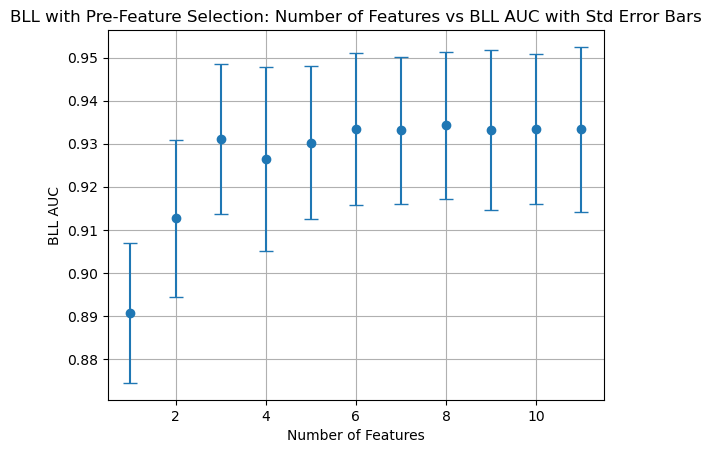

for 11 features, the important features are ['Flux1000' 'beta' 'Peak_Interval' 'Signif_Curve' 'HR1'
 'Variability_Index' 'HR4' 'HR3' 'Normalised_Flux_Peak'
 'loggedFlux_Density' 'PowerLaw_Index']
for 10 features, the important features are ['beta' 'Peak_Interval' 'Signif_Curve' 'HR1' 'Variability_Index' 'HR3'
 'HR4' 'loggedFlux_Density' 'Normalised_Flux_Peak' 'PowerLaw_Index']
for 9 features, the important features are ['Peak_Interval' 'Signif_Curve' 'HR1' 'Variability_Index' 'HR3' 'HR4'
 'Normalised_Flux_Peak' 'loggedFlux_Density' 'PowerLaw_Index']
for 8 features, the important features are ['Signif_Curve' 'HR1' 'Variability_Index' 'HR4' 'HR3' 'loggedFlux_Density'
 'Normalised_Flux_Peak' 'PowerLaw_Index']
for 7 features, the important features are ['HR1' 'Variability_Index' 'HR4' 'HR3' 'Normalised_Flux_Peak'
 'loggedFlux_Density' 'PowerLaw_Index']
for 6 features, the important features are ['Variability_Index' 'HR4' 'HR3' 'Normalised_Flux_Peak'
 'loggedFlux_Density' 'PowerLaw_Index']


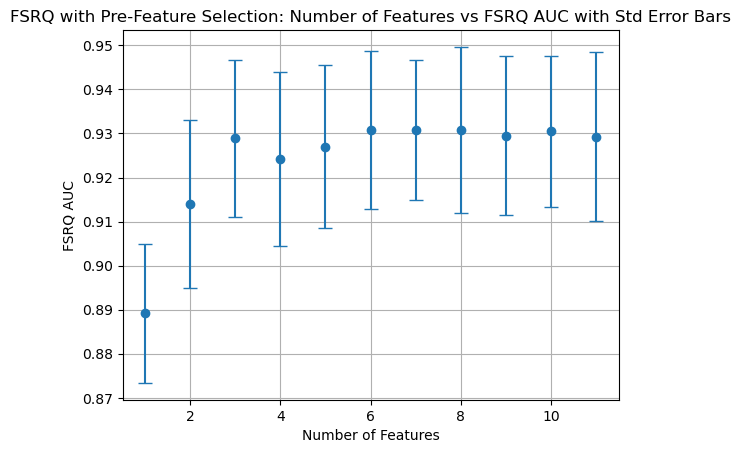

In [172]:
graph_feature_num_vs_AUC(X_fully_filtered_train, y_fully_filtered_train, title_prefix="BLL with Pre-Feature Selection", class_label = 'BLL', bootstrap=True, ccp_alpha=0, max_features='sqrt', min_samples_leaf=8, min_samples_split=3, n_estimators=150)
graph_feature_num_vs_AUC(X_fully_filtered_train, y_fully_filtered_train, title_prefix="FSRQ with Pre-Feature Selection", class_label = 'FSRQ', bootstrap=True, ccp_alpha=0, max_features='sqrt', min_samples_leaf=8, min_samples_split=3, n_estimators=150)


In [173]:
def plot_testing_roc_auc(X_train_array, y_train_array, X_test_array, y_test_array, positive_class_label, title_prefix):
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()
    
    # Set up the cross-validation
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    
    rf_final = RandomForestClassifier(bootstrap=True, ccp_alpha=0, max_features='sqrt', min_samples_leaf=8, min_samples_split=3, n_estimators=150, random_state=42)
    # Fit the model on the training data
    rf_final.fit(X_train_array, y_train_array)
    
    # Loop through each fold
    for i, (train, test) in enumerate(kf.split(X_test_array, y_test_array)):

        # Predict the probabilities on the test data
        if positive_class_label == 'BLL':
            y_proba = rf_final.predict_proba(X_test_array[test])[:,0] #0 for the positive class being BLL
            fpr, tpr, _ = roc_curve(y_test_array[test], y_proba, pos_label='BLL') # Calculate the ROC
        elif positive_class_label == 'FSRQ':
            y_proba = rf_final.predict_proba(X_test_array[test])[:,1] #1 for the positive class being FSRQ
            fpr, tpr, _ = roc_curve(y_test_array[test], y_proba, pos_label='FSRQ') # Calculate the ROC

        roc_auc = auc(fpr, tpr) # Calculate the AUC
        
        # Interpolate the TPR for a common mean FPR
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0 # making sure that the first value is 0 so that the curve starts at 0 (0% false positive rate and 0% true positive rate)
        tprs.append(interp_tpr)
        aucs.append(roc_auc)
        
        # Plot the ROC curve for the current fold
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i} (AUC = {roc_auc:.2f})')
    
    # Plot the mean ROC curve across all folds
    mean_tpr = np.mean(tprs, axis=0) # find the mean tpr
    mean_tpr[-1] = 1.0 # making sure that the last value of mean_tpr = 1
    mean_auc = auc(mean_fpr, mean_tpr) # find the mean AUC
    std_auc = np.std(aucs) # find standard deviation in the AUC
    
    ax.plot(mean_fpr, mean_tpr, color='b', lw=2, alpha=0.8, label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )
    
    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
    )
    
    # Final plot settings
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title=f"{title_prefix}:Receiver Operating Characteristic with Cross-Validation")
    ax.legend(loc="lower right")


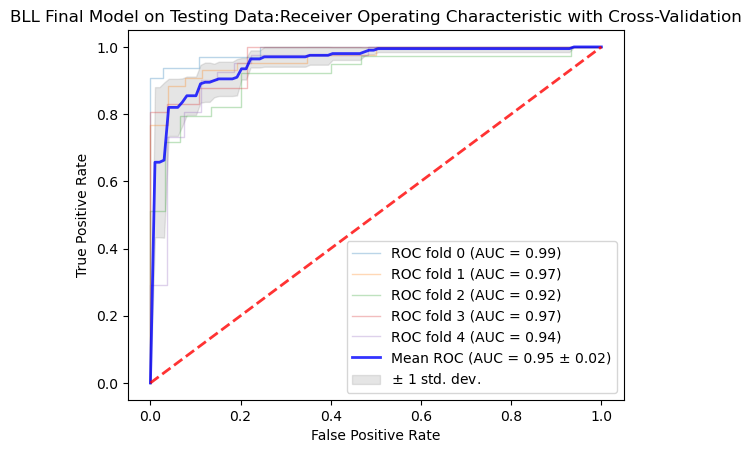

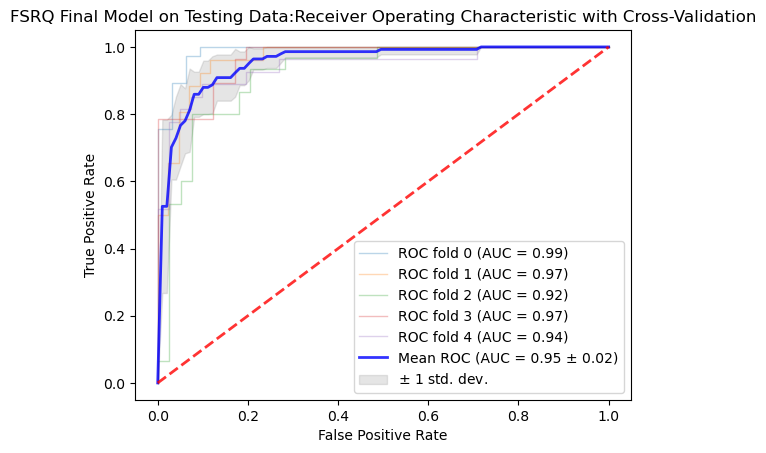

In [174]:
# comparing model on testing data

X_seven_feature_train_array = np.array(X_seven_feature_train)
y_seven_feature_train_array = np.array(y_seven_feature_train)

X_seven_feature_test_array = np.array(X_seven_feature_test)
y_seven_feature_test_array = np.array(y_seven_feature_test)


plot_testing_roc_auc(X_seven_feature_train_array, y_seven_feature_train_array, X_seven_feature_test_array, y_seven_feature_test_array, positive_class_label='BLL', title_prefix='BLL Final Model on Testing Data')
plot_testing_roc_auc(X_seven_feature_train_array, y_seven_feature_train_array, X_seven_feature_test_array, y_seven_feature_test_array, positive_class_label='FSRQ', title_prefix='FSRQ Final Model on Testing Data')






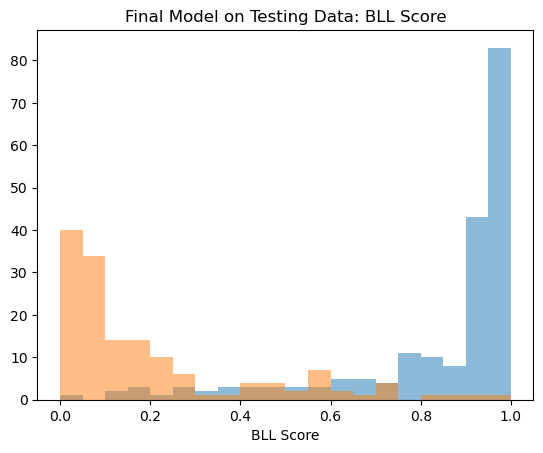

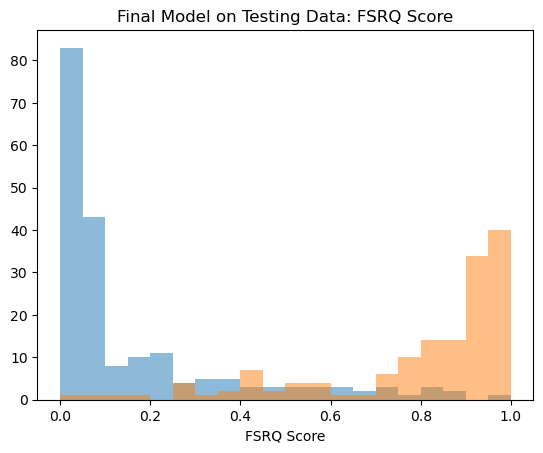

In [175]:
# Plotting Training Data Score Distributions on the final rf model for FSRQ and BLL
rf_final = RandomForestClassifier(bootstrap=True, ccp_alpha=0, max_features='sqrt', min_samples_leaf=8, min_samples_split=3, n_estimators=150, random_state=42)
# Fit the model on the training data
rf_final.fit(X_seven_feature_train_array, y_seven_feature_train_array)
    
# performing predictions on the test dataset
y_pred = rf_final.predict_proba(X_seven_feature_test_array)

plt.hist(y_pred[y_seven_feature_test_array=='BLL'][:,0], range= (0,1), bins=20, alpha=0.5) 
plt.hist(y_pred[y_seven_feature_test_array=='FSRQ'][:,0], range= (0,1), bins=20, alpha=0.5)  
plt.xlabel("BLL Score")
plt.title("Final Model on Testing Data: BLL Score")
plt.show()

plt.hist(y_pred[y_seven_feature_test_array=='BLL'][:,1], range= (0,1), bins=20, alpha=0.5) 
plt.hist(y_pred[y_seven_feature_test_array=='FSRQ'][:,1], range= (0,1), bins=20, alpha=0.5)  
plt.title("Final Model on Testing Data: FSRQ Score")
plt.xlabel("FSRQ Score")
plt.show()


In [205]:
# graphing precision and recall and f-score
def plot_testing_precision_recall_fscore(X_train_array, y_train_array, X_test_array, y_test_array, positive_class_label, title_prefix):

    precisions, recalls = [], []
    label_mapping = {'FSRQ': 0, 'BLL': 1} if positive_class_label == 'BLL' else {'FSRQ': 1, 'BLL': 0}

    y_train_array_numeric = np.array([label_mapping[label] for label in y_train_array])
    y_test_array_numeric = np.array([label_mapping[label] for label in y_test_array])

    mean_thresholds = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()
    
    # Set up the cross-validation
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    rf_final = RandomForestClassifier(bootstrap=True, ccp_alpha=0, max_features='sqrt', min_samples_leaf=6, min_samples_split=3, n_estimators=150)
    
    rf_final.fit(X_train_array, y_train_array_numeric)
    
    # Loop through each fold
    for i, (train, test) in enumerate(kf.split(X_test_array, y_test_array_numeric)):

        y_proba = rf_final.predict_proba(X_test_array[test])[:,1] #1 for the positive class
        precision, recall, thresholds = precision_recall_curve(y_test_array_numeric[test], y_proba, pos_label=1)
        # remove last element from precision and recall
        precision = precision[:-1]
        recall = recall[:-1]
    
        # calculate f1-score for threshold > t
        f1_scores = []
        for t in thresholds:
            f1 = f1_score(y_test_array_numeric[test], (y_proba > t).astype(int), pos_label=1)
            f1_scores.append(f1)

        ax.plot(thresholds, precision, lw=1, alpha=0.3, color="darkorange")
        ax.plot(thresholds, recall, lw=1, alpha=0.3, color="blue")
        ax.plot(thresholds, f1_scores, lw=1, alpha=0.3, color="green")

    
    # find average by looking at the full set of the cross_val_results
    cross_val_results = cross_val_predict(rf_final, X_test_array, y_test_array_numeric, cv=kf, method='predict_proba')  
    CV_f1_scores = []

    CV_precision, CV_recall, CV_thresholds = precision_recall_curve(y_test_array_numeric, cross_val_results[:,1], pos_label=1)
    for t in CV_thresholds:
        f1 = f1_score(y_test_array_numeric, (cross_val_results[:,1] > t).astype(int), pos_label=1)
        CV_f1_scores.append(f1)

        
    ax.plot(CV_thresholds, CV_precision[:-1], lw=1, alpha=1, color="darkorange", label='Precision')
    ax.plot(CV_thresholds, CV_recall[:-1], lw=1, alpha=1, color="darkblue", label='Recall')
    ax.plot(CV_thresholds, CV_f1_scores, lw=1, alpha=1, color="green", label='F1-score')
    ax.axhline(y=0.90, color='r', linestyle='--', label='0.90')
    
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
    ax.grid(True)
    
    # Set labels and titles
    ax.set(xlabel="Threshold", ylabel="Score", title=f"{title_prefix}: Precision and Recall vs. Threshold")

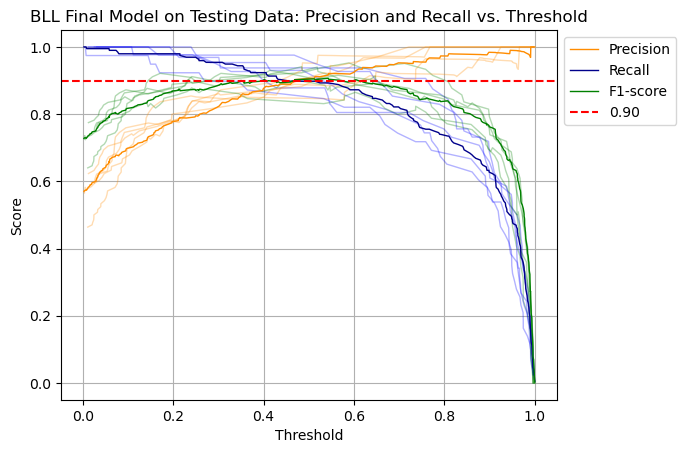

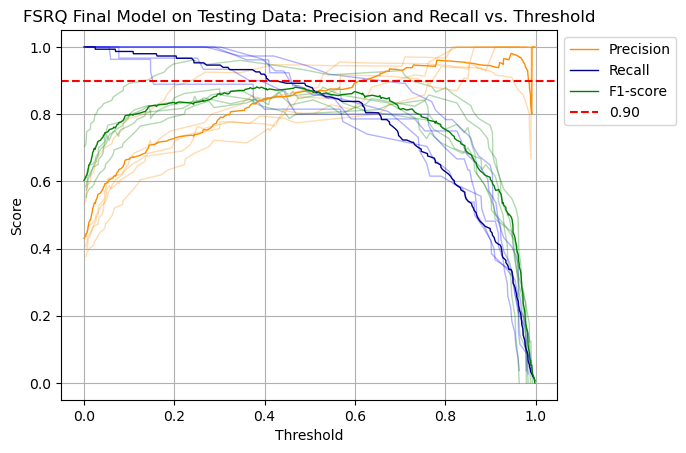

In [206]:
plot_testing_precision_recall_fscore(X_seven_feature_train_array, y_seven_feature_train_array, X_seven_feature_test_array, y_seven_feature_test_array, positive_class_label='BLL', title_prefix='BLL Final Model on Testing Data')
plot_testing_precision_recall_fscore(X_seven_feature_train_array, y_seven_feature_train_array, X_seven_feature_test_array, y_seven_feature_test_array, positive_class_label='FSRQ', title_prefix='FSRQ Final Model on Testing Data')


In [207]:
def one_line_plot_testing_precision_recall_fscore(X_train_array, y_train_array, X_test_array, y_test_array, positive_class_label, title_prefix):
    rf_final = RandomForestClassifier(bootstrap=True, ccp_alpha=0, max_features='sqrt', min_samples_leaf=8, min_samples_split=3, n_estimators=150, random_state=42)
    
    label_mapping = {'FSRQ': 0, 'BLL': 1} if positive_class_label == 'BLL' else {'FSRQ': 1, 'BLL': 0}
    
    y_train_array_numeric = np.array([label_mapping[label] for label in y_train_array])
    y_test_array_numeric = np.array([label_mapping[label] for label in y_test_array])
    
    # Train the model on X_train and Y_train
    rf_final.fit(X_train_array, y_train_array_numeric)
    
    # Predict probabilities on the test set
    y_proba = rf_final.predict_proba(X_test_array)[:, 1]  # Probabilities for the positive class
    
    # Calculate precision, recall, and thresholds using precision_recall_curve
    precisions, recalls, thresholds = precision_recall_curve(y_test_array_numeric, y_proba, pos_label=1)
    
    f1_scores = []
    max_f1_score = 0
    max_at_threshold = -10;
    threshold_for_precision_90 = None
    threshold_for_recall_85 = None
    for i, threshold in enumerate(thresholds):
        # Convert probabilities to binary predictions based on threshold
        y_pred = (y_proba >= threshold).astype(int)
        
        # Calculate F1 score
        f1 = f1_score(y_test_array_numeric, y_pred, pos_label=1)
        f1_scores.append(f1)
        if f1 > max_f1_score:
            max_f1_score = f1
            max_at_threshold = threshold
        if precisions[i] > 0.90 and threshold_for_precision_90 is None:
            threshold_for_precision_90 = threshold
        if recalls[i] <= 0.85 and threshold_for_recall_85 is None:
            threshold_for_recall_85 = threshold
    
    # Plot precision vs. threshold
   
    
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precisions[:-1], label='Precision', color='darkorange')
    plt.plot(thresholds, recalls[:-1], lw=1, alpha=1, color="darkblue", label='Recall')
    plt.plot(thresholds, f1_scores, lw=1, alpha=1, color="green", label='F1-score')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(f'{title_prefix}: Precision and Recall vs. Threshold on Test Set')
    plt.legend()
    plt.grid()
    plt.axhline(y=0.90, color='r', linestyle='--', label='90')
    plt.show()
    print(f'max_f1_score: {max_f1_score}, with threshold = {max_at_threshold}')
    print(f'threshold_for_precision_90: {threshold_for_precision_90}')
    print(f'threshold_for_recall_85: {threshold_for_recall_85}')
    

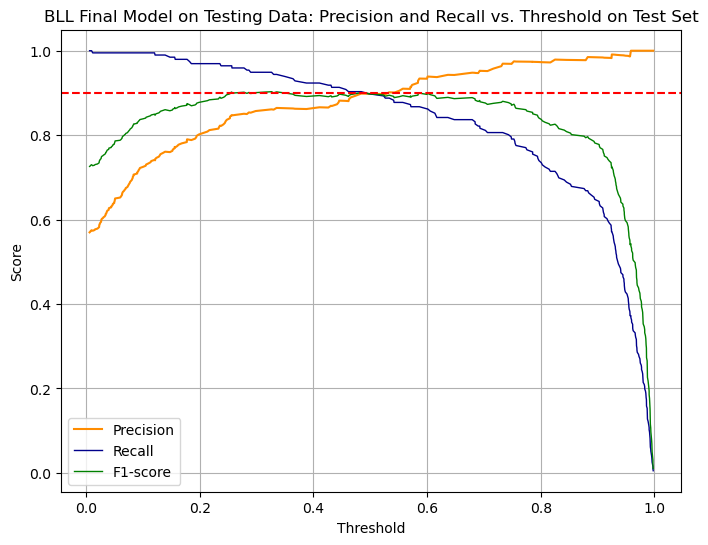

max_f1_score: 0.9029126213592233, with threshold = 0.326307215303322
threshold_for_precision_90: 0.5334418035602874
threshold_for_recall_85: 0.6154914755126134


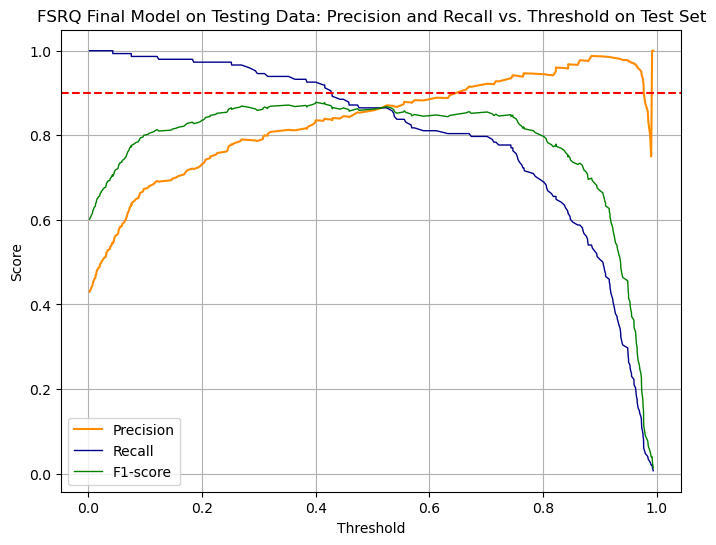

max_f1_score: 0.8782051282051282, with threshold = 0.4001584539215042
threshold_for_precision_90: 0.6495631110490243
threshold_for_recall_85: 0.538275379191734


In [208]:
one_line_plot_testing_precision_recall_fscore(X_seven_feature_train_array, y_seven_feature_train_array, X_seven_feature_test_array, y_seven_feature_test_array, positive_class_label='BLL', title_prefix='BLL Final Model on Testing Data')
one_line_plot_testing_precision_recall_fscore(X_seven_feature_train_array, y_seven_feature_train_array, X_seven_feature_test_array, y_seven_feature_test_array, positive_class_label='FSRQ', title_prefix='FSRQ Final Model on Testing Data')


In [198]:
# # creating a RF classifier
# rf_final = RandomForestClassifier(bootstrap=True, ccp_alpha=0, max_features='sqrt', min_samples_leaf=8, min_samples_split=3, n_estimators=150, random_state=42)
 
# # Training the model on the training dataset
# # fit function is used to train the model using the training sets as parameters
# rf_final.fit(X_seven_feature_train_array, y_seven_feature_train_array)
 
# # performing predictions on the test dataset
# y_pred = rf_final.predict(X_seven_feature_test_array)
 

# accuracy = accuracy_score(y_seven_feature_test_array, y_pred)
# print("Accuracy:", accuracy)

In [199]:
# def accuracy_score_with_threshold(X_train_array, y_train_array, X_test_array, y_test_array, threshold, positive_class_label, title_prefix):
#     # creating a RF classifier
#     rf_final = RandomForestClassifier(bootstrap=True, ccp_alpha=0, max_features='sqrt', min_samples_leaf=8, min_samples_split=3, n_estimators=150, random_state=42)
    
#     label_mapping = {'FSRQ': 0, 'BLL': 1} if positive_class_label == 'BLL' else {'FSRQ': 1, 'BLL': 0}
#     y_train_array_numeric = np.array([label_mapping[label] for label in y_train_array])
#     y_test_array_numeric = np.array([label_mapping[label] for label in y_test_array])
        
#     # Training the model on the training dataset
#     # fit function is used to train the model using the training sets as parameters
#     rf_final.fit(X_train_array, y_train_array_numeric)
    
#     # Perform predictions using predict_proba to get the probabilities
#     y_proba = rf_final.predict_proba(X_test_array)[:, 1]  

#     # Apply a threshold 
#     y_pred_thresholded = (y_proba >= threshold).astype(int)
#     # Calculate accuracy with the thresholded predictions
#     accuracy = accuracy_score(y_test_array_numeric, y_pred_thresholded)
#     print(f"{title_prefix} accuracy with threshold >= {threshold}:", accuracy)


In [200]:
# accuracy_score_with_threshold(X_seven_feature_train_array, y_seven_feature_train_array, X_seven_feature_test_array, y_seven_feature_test_array, threshold=0.53, positive_class_label='BLL', title_prefix='BLL Final Model on Testing Data')
# accuracy_score_with_threshold(X_seven_feature_train_array, y_seven_feature_train_array, X_seven_feature_test_array, y_seven_feature_test_array, threshold=0.65, positive_class_label='FSRQ', title_prefix='FSRQ Final Model on Testing Data')

In [201]:
def accuracy_score_with_BLL_and_FSRQ_threshold(X_train, y_train, X_test, y_test, threshold, positive_class_label, title_prefix):
    X_train_array = np.array(X_train)
    y_train_array = np.array(y_train)
    X_test_array = np.array(X_test)
    y_test_array = np.array(y_test)

    # creating a RF classifier
    rf_final = RandomForestClassifier(bootstrap=True, ccp_alpha=0, max_features='sqrt', min_samples_leaf=8, min_samples_split=3, n_estimators=150, random_state=42)
    
    label_mapping = {'FSRQ': 0, 'BLL': 1} if positive_class_label == 'BLL' else {'FSRQ': 1, 'BLL': 0}
    y_train_array_numeric = np.array([label_mapping[label] for label in y_train_array])
    y_test_array_numeric = np.array([label_mapping[label] for label in y_test_array])
        
    # Training the model on the training dataset
    # fit function is used to train the model using the training sets as parameters
    rf_final.fit(X_train_array, y_train_array_numeric)
    
    # Perform predictions using predict_proba to get the probabilities
    y_proba = rf_final.predict_proba(X_test_array)[:, 1] 

    # Apply threshold
    y_pred_thresholded = (y_proba >= threshold).astype(int)

    
    # Filter only the points where the predicted label is 1 (positive class)
    mask_positive_class = y_pred_thresholded == 1
    y_test_positive = y_test_array_numeric[mask_positive_class]
    y_pred_positive = y_pred_thresholded[mask_positive_class]
    num_predicted_positive_class = len(y_pred_positive)

    # find the number of true positives
    mask_true_positive_class = y_test_array_numeric == 1
    y_test_true_positive = y_test_array_numeric[mask_true_positive_class]
    num_of_class_type = len(y_test_true_positive)

    # find number of wrong predictions
    mask_wrong_predictions = y_test_positive == 0
    num_predicted_wrong_class = len(y_pred_positive[mask_wrong_predictions])
    
    # Calculate accuracy only for the points labeled as 1
    accuracy = accuracy_score(y_test_positive, y_pred_positive)

    print(f"{title_prefix} {positive_class_label} accuracy with threshold >= {threshold}:", accuracy)
    print(f"Found {num_predicted_positive_class} predicted positives of {positive_class_label}. There were originally {num_of_class_type} true positive values of {positive_class_label}. Made {num_predicted_wrong_class} wrong predictions in the threshold of {num_predicted_positive_class} values.")


In [202]:
accuracy_score_with_BLL_and_FSRQ_threshold(X_seven_feature_train_array, y_seven_feature_train_array, X_seven_feature_test_array, y_seven_feature_test_array, threshold=0.53, positive_class_label='BLL', title_prefix='BLL: 3FGL BCU compared to 4FGL Associations')
accuracy_score_with_BLL_and_FSRQ_threshold(X_seven_feature_train_array, y_seven_feature_train_array, X_seven_feature_test_array, y_seven_feature_test_array, threshold=0.65, positive_class_label='FSRQ', title_prefix='FSRQ: 3FGL BCU compared to 4FGL Associations')


BLL: 3FGL BCU compared to 4FGL Associations BLL accuracy with threshold >= 0.53: 0.9015544041450777
Found 193 predicted positives of BLL. There were originally 196 true positive values of BLL. Made 19 wrong predictions in the threshold of 193 values.
FSRQ: 3FGL BCU compared to 4FGL Associations FSRQ accuracy with threshold >= 0.65: 0.9083969465648855
Found 131 predicted positives of FSRQ. There were originally 148 true positive values of FSRQ. Made 12 wrong predictions in the threshold of 131 values.
